In [1]:
import os
from os.path import join
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from helpers import util

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

DATA_DIR = '../data'

In [292]:
players = pd.read_csv(join(DATA_DIR, 'raw', 'players.csv'))
plays = pd.read_parquet(join(DATA_DIR, '01_processed', 'plays.parquet'))
games = pd.read_parquet(join(DATA_DIR, '01_processed', 'games.parquet'))
attrib_df = pd.read_csv('../results/oline_loo_attribution_90.csv')

players = util.uncamelcase_columns(players)

In [3]:
ol_attrib = (
    attrib_df.merge(
        players[['nfl_id', 'display_name','position']],
        left_on='player_id',
        right_on='nfl_id',
        how='left',
        suffixes=('', '_roster')
    ).groupby('player_id').aggregate({
        'display_name': 'first',
        'position_roster': 'first',
        'fc_attribution': 'mean',
        'position': 'count',
    }).reset_index().sort_values('fc_attribution', ascending=False).rename(columns={
        'position': 'n_plays',
    })
    # }).query('n_plays > 80').reset_index(drop=True)
)

ol_attrib.head()

,player_id,display_name,position_roster,fc_attribution,n_plays
250,55125.0,Lewis Kidd,G,0.080842,11
159,48514.0,Iosua Opeta,G,0.080624,20
85,44949.0,Sean Harlow,C,0.076527,26
183,52588.0,Hakeem Adeniji,G,0.075669,1
108,46143.0,Geron Christian,T,0.074507,5


In [4]:
ol_attrib = (
    ol_attrib.assign(
        fc_attribution_rescaled=lambda x: (
            x.fc_attribution - x.fc_attribution.min() + 0.005
        ) / (x.fc_attribution.max() - x.fc_attribution.min() + 0.005) *.98
    )
)

In [5]:
ol_attrib.head()

,player_id,display_name,position_roster,fc_attribution,n_plays,fc_attribution_rescaled
250,55125.0,Lewis Kidd,G,0.080842,11,0.980000
159,48514.0,Iosua Opeta,G,0.080624,20,0.977328
85,44949.0,Sean Harlow,C,0.076527,26,0.927251
183,52588.0,Hakeem Adeniji,G,0.075669,1,0.916761
108,46143.0,Geron Christian,T,0.074507,5,0.902551


# 8. Save the data

In [6]:
cols = ['display_name','n_plays','fc_attribution_rescaled']
rename_dict = {
    'display_name': 'Player',
    'n_plays': 'N Plays',
    'fc_attribution_rescaled': 'FCA'
}
center_attribution = (
    ol_attrib.query('position_roster == "C"')
    [cols]
    .rename(columns=rename_dict)
    .assign(
        FCA=lambda x: x['FCA'].round(3) * 100,
        N_Plays=lambda x: x['N Plays'].astype(int)
    )
    .rename(columns={
        'N Plays': 'N Plays',
    })
    .drop(columns=['N_Plays'])
    .sort_values('FCA', ascending=False)
)
# center_attribution.to_csv('center_attribution.csv', index=False)

In [7]:
cols = ['display_name','n_plays','fc_attribution_rescaled']
rename_dict = {
    'display_name': 'Player',
    'n_plays': 'N Plays',
    'fc_attribution_rescaled': 'FCA'
}
gaurd_attribution = (
    ol_attrib.query('position_roster == "G"')
    [cols]
    .rename(columns=rename_dict)
    .assign(
        FCA=lambda x: x['FCA'].round(3) * 100,
        N_Plays=lambda x: x['N Plays'].astype(int)
    )
    .rename(columns={
        'N Plays': 'N Plays',
    })
    .drop(columns=['N_Plays'])
    .sort_values('FCA', ascending=False)
)
# gaurd_attribution.to_csv('gaurd_attribution.csv', index=False)

In [8]:
cols = ['display_name','n_plays','fc_attribution_rescaled']
rename_dict = {
    'display_name': 'Player',
    'n_plays': 'N Plays',
    'fc_attribution_rescaled': 'FCA'
}
tackle_attribution = (
    ol_attrib.query('position_roster == "T"')
    [cols]
    .rename(columns=rename_dict)
    .assign(
        FCA=lambda x: x['FCA'].round(3) * 100,
        N_Plays=lambda x: x['N Plays'].astype(int)
    )
    .rename(columns={
        'N Plays': 'N Plays',
    })
    .drop(columns=['N_Plays'])
    .sort_values('FCA', ascending=False)
)

# tackle_attribution.to_csv('tackle_attribution.csv', index=False)

In [9]:
players.head()

,nfl_id,height,weight,birth_date,college_name,position,display_name
0,25511,6-4,225,1977-08-03,Michigan,QB,Tom Brady
1,29550,6-4,328,1982-01-22,Arkansas,T,Jason Peters
2,29851,6-2,225,1983-12-02,California,QB,Aaron Rodgers
3,30842,6-6,267,1984-05-19,UCLA,TE,Marcedes Lewis
4,33084,6-4,217,1985-05-17,Boston College,QB,Matt Ryan


In [10]:
import nfl_data_py as nfl

headshots = (
    nfl.import_seasonal_rosters([2022])
    [['team','gsis_it_id','position','depth_chart_position','headshot_url']]
    .query('position == "OL"')
    .drop('position', axis=1)
)

cols = ['team', 'headshot_url', 'Player',
       'N Plays', 'FCA']

tackles = (
    players.merge(
        headshots.assign(
            gsis_it_id=lambda x: x['gsis_it_id'].astype('float')
        ),
        left_on='nfl_id',
        right_on='gsis_it_id',
        how='inner'
    ).drop(columns=['gsis_it_id'])
    .merge(
        tackle_attribution,
        left_on='display_name',
        right_on='Player',
        how='inner'
    )
)[cols]

centers = (
    players.merge(
        headshots.assign(
            gsis_it_id=lambda x: x['gsis_it_id'].astype('float')
        ),
        left_on='nfl_id',
        right_on='gsis_it_id',
        how='inner'
    ).drop(columns=['gsis_it_id'])
    .merge(
        center_attribution,
        left_on='display_name',
        right_on='Player',
        how='inner'
    )
    .query('position == "C"')
)[cols]

guards = (
    players.merge(
        headshots.assign(
            gsis_it_id=lambda x: x['gsis_it_id'].astype('float')
        ),
        left_on='nfl_id',
        right_on='gsis_it_id',
        how='inner'
    ).drop(columns=['gsis_it_id'])
    .merge(
        gaurd_attribution,
        left_on='display_name',
        right_on='Player',
        how='inner'
    )
    .query('position == "G"')
)[cols]

In [11]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.path import Path
from matplotlib.patches import PathPatch

def circled_image(
    ax: plt.Axes, 
    path: str, 
    *,
    bg_circle: bool = False,
    bg_circle_kwargs: dict = None,
    zoom: float = 0.9,
    **imshow_kwargs
):
    """Plots an image cropped to a circle, aligned to cell center."""
    img = plt.imread(path)

    # Crop the image to be a perfect square
    h, w, _ = img.shape
    if h != w:
        min_dim = min(h, w)
        start_h = (h - min_dim) // 2
        start_w = (w - min_dim) // 2
        img = img[start_h:start_h + min_dim, start_w:start_w + min_dim, :]

    # Normalize axes
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis("off")

    # Background circle
    if bg_circle:
        bg_kw = {
            "facecolor": "lightgray",
            "edgecolor": "none",
            "zorder": 0
        }
        if bg_circle_kwargs:
            bg_kw.update(bg_circle_kwargs)
        ax.add_patch(Circle((0.5, 0.5), 0.5 * zoom, **bg_kw))

    # Plot image
    im = ax.imshow(img, extent=(0, 1, 0, 1), **imshow_kwargs)

    # Clip to circle
    clip_circle = Circle((0.5, 0.5), 0.5 * zoom, transform=ax.transData)
    im.set_clip_path(clip_circle)

    return im

def regular_image(
    ax: plt.Axes,
    path: str,
    *,
    zoom: float = 0.9,
    **imshow_kwargs
):
    """Plots an image without cropping, aligned to cell center."""
    img = plt.imread(path)

    # Normalize axes
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis("off")

    # Plot image
    im = ax.imshow(img, extent=(0, 1, 0, 1), **imshow_kwargs)

    return im

# Tackles

Skipped ../data/images/headshots/Brady_Christensen_CAR.png - already exists
Skipped ../data/images/headshots/Dillon_Radunz_TEN.png - already exists
Skipped ../data/images/headshots/Matt_Pryor_IND.png - already exists
Skipped ../data/images/headshots/Abraham_Lucas_SEA.png - already exists
Skipped ../data/images/headshots/Jordan_Mailata_PHI.png - already exists
Skipped ../data/images/headshots/Braden_Smith_IND.png - already exists
Skipped ../data/images/headshots/La'el_Collins_CIN.png - already exists
Skipped ../data/images/headshots/Teven_Jenkins_CHI.png - already exists
Skipped ../data/images/headshots/Cornelius_Lucas_WAS.png - already exists
Skipped ../data/images/headshots/Lane_Johnson_PHI.png - already exists
Skipped ../data/images/team_logos/ARI_.png - already exists
Skipped ../data/images/team_logos/ATL_.png - already exists
Skipped ../data/images/team_logos/BAL_.png - already exists
Skipped ../data/images/team_logos/BUF_.png - already exists
Skipped ../data/images/team_logos/CAR_

/Users/lukeneuendorf/miniforge3/envs/nfl-oline/lib/python3.11/site-packages/plottable/table.py:543: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  cell.text.set_bbox(


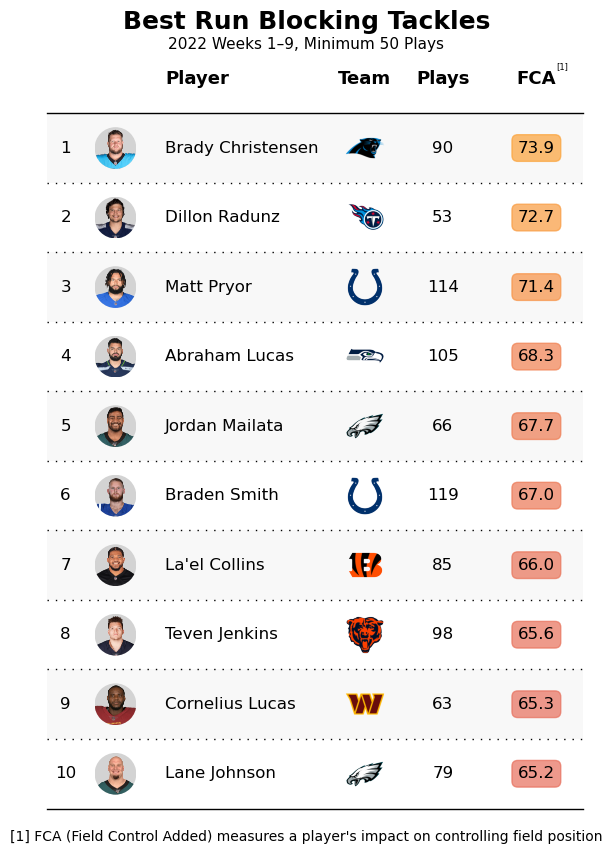

Skipped ../data/images/headshots/Rob_Havenstein_LA.png - already exists
Skipped ../data/images/headshots/Terence_Steele_DAL.png - already exists
Skipped ../data/images/headshots/Charles_Cross_SEA.png - already exists
Skipped ../data/images/headshots/Taylor_Moton_CAR.png - already exists
Skipped ../data/images/headshots/Charles_Leno_WAS.png - already exists
Skipped ../data/images/headshots/Jedrick_Wills_CLE.png - already exists
Skipped ../data/images/headshots/Jack_Conklin_CLE.png - already exists
Skipped ../data/images/headshots/Nicholas_Petit-Frere_TEN.png - already exists
Skipped ../data/images/headshots/Jonah_Williams_CIN.png - already exists
Skipped ../data/images/headshots/Tristan_Wirfs_TB.png - already exists
Skipped ../data/images/team_logos/ARI_.png - already exists
Skipped ../data/images/team_logos/ATL_.png - already exists
Skipped ../data/images/team_logos/BAL_.png - already exists
Skipped ../data/images/team_logos/BUF_.png - already exists
Skipped ../data/images/team_logos/C

/Users/lukeneuendorf/miniforge3/envs/nfl-oline/lib/python3.11/site-packages/plottable/table.py:543: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  cell.text.set_bbox(


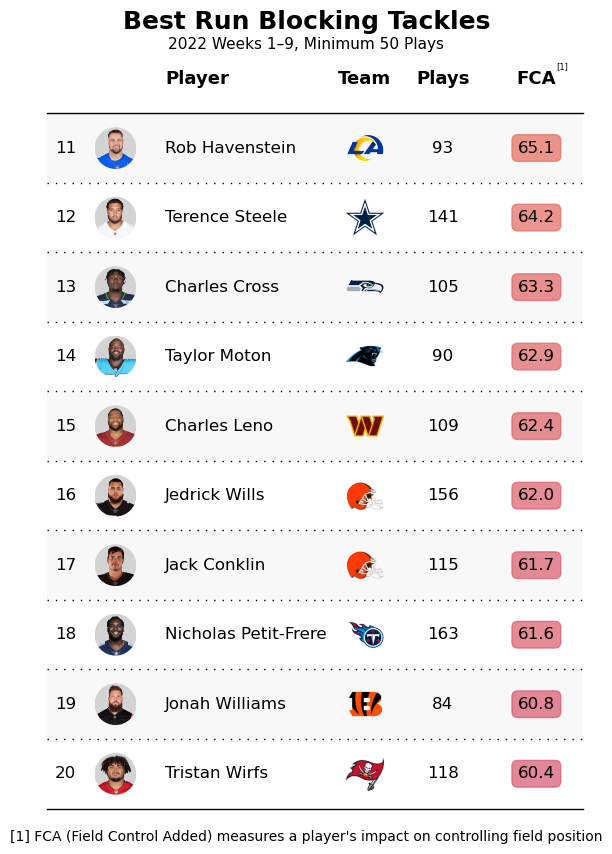

In [18]:
import matplotlib
from plottable import ColumnDefinition, Table
from plottable.cmap import normed_cmap
import requests
from io import BytesIO
from PIL import Image

tackles_t20 = (
    tackles
    [tackles['N Plays'] >= 50]
    .sort_values('FCA', ascending=False)
    .reset_index(drop=True)
    .head(10)
)

tackles_t20.insert(0, "Rank", range(1, len(tackles_t20) + 1))
tackles_t20.set_index('Rank', inplace=True)

HEADSHOT_DIR = join(DATA_DIR, 'images', 'headshots')
os.makedirs(HEADSHOT_DIR, exist_ok=True)

def download_image(url, save_path, playername, team):
    try:
        filename = f"{playername.replace(' ', '_').replace('.', '')}_{team}.png"
        filepath = os.path.join(save_path, filename)

        # Skip if already exists
        if os.path.exists(filepath):
            print(f"Skipped {filepath} - already exists")
            return

        # Download
        response = requests.get(url, stream=True)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content)).convert("RGBA")

        # Get background color (top-left pixel)
        datas = img.getdata()
        new_data = []
        bg_color = datas[0]  # likely green screen background

        for item in datas:
            # Match background color exactly (RGB only)
            if item[:3] == bg_color[:3]:
                new_data.append((255, 255, 255, 0))  # transparent
            else:
                new_data.append(item)

        img.putdata(new_data)
        img.save(filepath, format="PNG")
        print(f"Downloaded and saved transparent image to {filepath}")

    except Exception as e:
        print(f"Error downloading image from {url}: {e}")


for row in tackles_t20.itertuples():
    download_image(
        row.headshot_url,
        HEADSHOT_DIR,
        row.Player,
        row.team
    )

tackles_t20['headshot_path'] = tackles_t20.apply(
    lambda row: os.path.join(
        HEADSHOT_DIR,
        f"{row.Player.replace(' ', '_').replace('.','')}_{row.team}.png"
    ),
    axis=1
)

teams = nfl.import_team_desc()

TEAM_LOGO_DIR = join(DATA_DIR, 'images', 'team_logos')
os.makedirs(TEAM_LOGO_DIR, exist_ok=True)
for row in teams.itertuples():
    download_image(
        row.team_logo_espn,
        TEAM_LOGO_DIR,
        row.team_abbr,
        ""
    )

tackles_t20['team_logo_path'] = tackles_t20.apply(
    lambda row: os.path.join(
        TEAM_LOGO_DIR,
        f"{row.team}_.png"
    ),
    axis=1
)

col_defs = [
    ColumnDefinition(
        name="Rank",
        title="",
        textprops={"ha": "center", "weight": "normal"},
        width=0.3,
    ),
    ColumnDefinition(
        name="headshot_path",
        title="",
        textprops={"ha": "right"},
        width=.5,
        plot_fn=lambda ax, val: circled_image(
            ax, 
            val,
            bg_circle=True,
            zoom=1.0,
        )
    ),
    ColumnDefinition(
        name="Player",
        textprops={"ha": "left", "weight": "normal"},
        width=1.5,
    ),
    ColumnDefinition(
        name="team_logo_path",
        title="Team",
        textprops={"ha": "center"},
        width=0.5,
        plot_fn=lambda ax, val: regular_image(
            ax, 
            val,
            zoom=0.8,        
        )
    ),
    ColumnDefinition(
        name="N Plays",
        title="Plays",
        textprops={"ha": "center"},
        width=0.75,
    ),
    ColumnDefinition(
        name="FCA",
        title="FCA",
        textprops={
            "ha": "center",
            "bbox": {"boxstyle": "round,pad=0.35", "edgecolor": "none", "alpha": 0.7},
        },
        formatter=lambda x: f"{x:.1f}",
        cmap=normed_cmap(tackles["FCA"], cmap=matplotlib.cm.plasma, num_stds=2.5),
        width=0.75,
    )
]

# Figure setup
plt.rcParams["font.family"] = ["DejaVu Sans"]
fig, ax = plt.subplots(figsize=(7, 10))

cols = ["headshot_path", "Player", "team_logo_path", "N Plays", "FCA"]

table = Table(
    tackles_t20[cols],
    column_definitions=col_defs,
    row_dividers=True,
    footer_divider=True,
    ax=ax,
    textprops={"fontsize": 12, "weight": "normal"},
    row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
    col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
    column_border_kw={"linewidth": 1, "linestyle": "-"},
    even_row_color="#f8f8f8",  # Light gray for even rows
)
# Make only the column headers bold (and optionally tweak size)
for cell in table.col_label_row.cells:
    if hasattr(cell, "text") and cell.text is not None:
        cell.text.set_fontweight("bold")
        cell.text.set_fontsize(13)

# Title & footer
fig.suptitle(
    "Best Run Blocking Tackles",
    fontsize=18,
    fontweight="bold",
    y=0.9,
    ha="center", va="center",
)

# Subtitle
fig.text(
    0.5, 0.878,  # Position just below main title
    "2022 Weeks 1–9, Minimum 50 Plays",
    fontsize=11,
    ha="center", va="center"
)

fig.text(
    0.5, 0.085,
    "[1] FCA (Field Control Added) measures a player's impact on controlling field position",
    ha="center", va="center", fontsize=10
)

fig.text(
    0.865, 0.855,
    "[1]",
    ha="center", va="center", fontsize=6
)

# save image to ../results/oline_run_blocking_grades/tackles_t20.png
os.makedirs('../results/oline_run_blocking_grades', exist_ok=True)
plt.savefig('../results/oline_run_blocking_grades/tackles_t10.png', bbox_inches='tight', dpi=300)

plt.show()
import matplotlib
from plottable import ColumnDefinition, Table
from plottable.cmap import normed_cmap
import requests
from io import BytesIO
from PIL import Image

tackles_t20 = (
    tackles
    [tackles['N Plays'] >= 50]
    .sort_values('FCA', ascending=False)
    .reset_index(drop=True)
    .iloc[10:20]  # Get the next 10 after the top 10
)

tackles_t20.insert(0, "Rank", range(11, 21))
tackles_t20.set_index('Rank', inplace=True)

HEADSHOT_DIR = join(DATA_DIR, 'images', 'headshots')
os.makedirs(HEADSHOT_DIR, exist_ok=True)

def download_image(url, save_path, playername, team):
    try:
        filename = f"{playername.replace(' ', '_').replace('.', '')}_{team}.png"
        filepath = os.path.join(save_path, filename)

        # Skip if already exists
        if os.path.exists(filepath):
            print(f"Skipped {filepath} - already exists")
            return

        # Download
        response = requests.get(url, stream=True)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content)).convert("RGBA")

        # Get background color (top-left pixel)
        datas = img.getdata()
        new_data = []
        bg_color = datas[0]  # likely green screen background

        for item in datas:
            # Match background color exactly (RGB only)
            if item[:3] == bg_color[:3]:
                new_data.append((255, 255, 255, 0))  # transparent
            else:
                new_data.append(item)

        img.putdata(new_data)
        img.save(filepath, format="PNG")
        print(f"Downloaded and saved transparent image to {filepath}")

    except Exception as e:
        print(f"Error downloading image from {url}: {e}")


for row in tackles_t20.itertuples():
    download_image(
        row.headshot_url,
        HEADSHOT_DIR,
        row.Player,
        row.team
    )

tackles_t20['headshot_path'] = tackles_t20.apply(
    lambda row: os.path.join(
        HEADSHOT_DIR,
        f"{row.Player.replace(' ', '_').replace('.','')}_{row.team}.png"
    ),
    axis=1
)

teams = nfl.import_team_desc()

TEAM_LOGO_DIR = join(DATA_DIR, 'images', 'team_logos')
os.makedirs(TEAM_LOGO_DIR, exist_ok=True)
for row in teams.itertuples():
    download_image(
        row.team_logo_espn,
        TEAM_LOGO_DIR,
        row.team_abbr,
        ""
    )

tackles_t20['team_logo_path'] = tackles_t20.apply(
    lambda row: os.path.join(
        TEAM_LOGO_DIR,
        f"{row.team}_.png"
    ),
    axis=1
)

col_defs = [
    ColumnDefinition(
        name="Rank",
        title="",
        textprops={"ha": "center", "weight": "normal"},
        width=0.3,
    ),
    ColumnDefinition(
        name="headshot_path",
        title="",
        textprops={"ha": "right"},
        width=.5,
        plot_fn=lambda ax, val: circled_image(
            ax, 
            val,
            bg_circle=True,
            zoom=1.0,
        )
    ),
    ColumnDefinition(
        name="Player",
        textprops={"ha": "left", "weight": "normal"},
        width=1.5,
    ),
    ColumnDefinition(
        name="team_logo_path",
        title="Team",
        textprops={"ha": "center"},
        width=0.5,
        plot_fn=lambda ax, val: regular_image(
            ax, 
            val,
            zoom=0.8,        
        )
    ),
    ColumnDefinition(
        name="N Plays",
        title="Plays",
        textprops={"ha": "center"},
        width=0.75,
    ),
    ColumnDefinition(
        name="FCA",
        title="FCA",
        textprops={
            "ha": "center",
            "bbox": {"boxstyle": "round,pad=0.35", "edgecolor": "none", "alpha": 0.7},
        },
        formatter=lambda x: f"{x:.1f}",
        cmap=normed_cmap(tackles["FCA"], cmap=matplotlib.cm.plasma, num_stds=2.5),
        width=0.75,
    )
]

# Figure setup
plt.rcParams["font.family"] = ["DejaVu Sans"]
fig, ax = plt.subplots(figsize=(7, 10))

cols = ["headshot_path", "Player", "team_logo_path", "N Plays", "FCA"]

table = Table(
    tackles_t20[cols],
    column_definitions=col_defs,
    row_dividers=True,
    footer_divider=True,
    ax=ax,
    textprops={"fontsize": 12, "weight": "normal"},
    row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
    col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
    column_border_kw={"linewidth": 1, "linestyle": "-"},
    even_row_color="#f8f8f8",  # Light gray for even rows
)
# Make only the column headers bold (and optionally tweak size)
for cell in table.col_label_row.cells:
    if hasattr(cell, "text") and cell.text is not None:
        cell.text.set_fontweight("bold")
        cell.text.set_fontsize(13)

# Title & footer
fig.suptitle(
    "Best Run Blocking Tackles",
    fontsize=18,
    fontweight="bold",
    y=0.9,
    ha="center", va="center",
)

# Subtitle
fig.text(
    0.5, 0.878,  # Position just below main title
    "2022 Weeks 1–9, Minimum 50 Plays",
    fontsize=11,
    ha="center", va="center"
)

fig.text(
    0.5, 0.085,
    "[1] FCA (Field Control Added) measures a player's impact on controlling field position",
    ha="center", va="center", fontsize=10
)

fig.text(
    0.865, 0.855,
    "[1]",
    ha="center", va="center", fontsize=6
)

# save image to ../results/oline_run_blocking_grades/tackles_t20.png
os.makedirs('../results/oline_run_blocking_grades', exist_ok=True)
plt.savefig('../results/oline_run_blocking_grades/tackles_t10_20.png', bbox_inches='tight', dpi=300)

plt.show()

# Gaurds

Skipped ../data/images/headshots/Joe_Thuney_KC.png - already exists
Skipped ../data/images/headshots/Michael_Onwenu_NE.png - already exists
Skipped ../data/images/headshots/Landon_Dickerson_PHI.png - already exists
Skipped ../data/images/headshots/Isaac_Seumalo_PHI.png - already exists
Skipped ../data/images/headshots/Gabe_Jackson_SEA.png - already exists
Skipped ../data/images/headshots/Laken_Tomlinson_NYJ.png - already exists
Skipped ../data/images/headshots/Saahdiq_Charles_WAS.png - already exists
Skipped ../data/images/headshots/Quenton_Nelson_IND.png - already exists
Skipped ../data/images/headshots/Joel_Bitonio_CLE.png - already exists
Skipped ../data/images/headshots/Alex_Cappa_CIN.png - already exists
Skipped ../data/images/team_logos/ARI_.png - already exists
Skipped ../data/images/team_logos/ATL_.png - already exists
Skipped ../data/images/team_logos/BAL_.png - already exists
Skipped ../data/images/team_logos/BUF_.png - already exists
Skipped ../data/images/team_logos/CAR_.pn

/Users/lukeneuendorf/miniforge3/envs/nfl-oline/lib/python3.11/site-packages/plottable/table.py:543: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  cell.text.set_bbox(


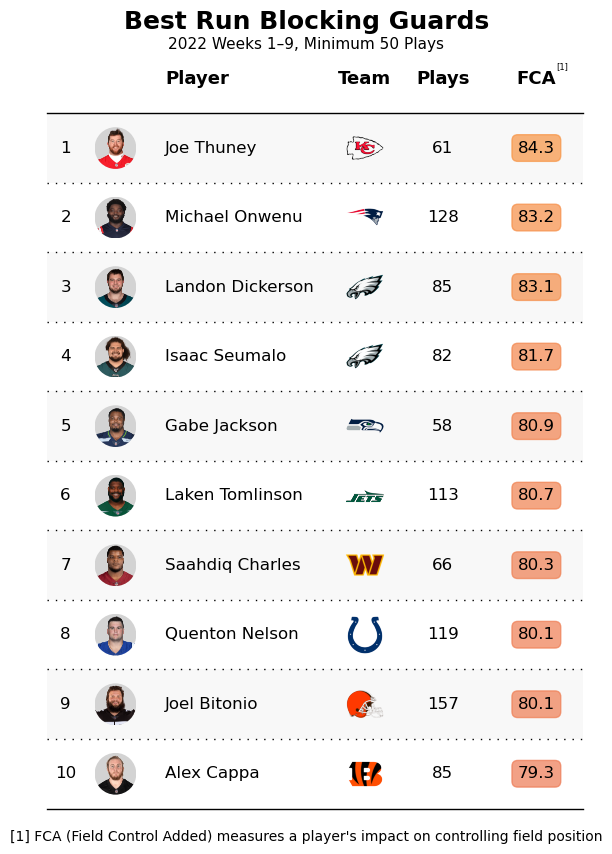

Skipped ../data/images/headshots/Andrew_Norwell_WAS.png - already exists
Skipped ../data/images/headshots/Shaquille_Mason_TB.png - already exists
Skipped ../data/images/headshots/Cole_Strange_NE.png - already exists
Skipped ../data/images/headshots/Austin_Corbett_CAR.png - already exists
Skipped ../data/images/headshots/Isaiah_Wynn_NE.png - already exists
Skipped ../data/images/headshots/Will_Hernandez_ARI.png - already exists
Skipped ../data/images/headshots/Luke_Goedeke_TB.png - already exists
Skipped ../data/images/headshots/Nate_Herbig_NYJ.png - already exists
Skipped ../data/images/headshots/Cordell_Volson_CIN.png - already exists
Skipped ../data/images/headshots/AJ_Cann_HOU.png - already exists
Skipped ../data/images/team_logos/ARI_.png - already exists
Skipped ../data/images/team_logos/ATL_.png - already exists
Skipped ../data/images/team_logos/BAL_.png - already exists
Skipped ../data/images/team_logos/BUF_.png - already exists
Skipped ../data/images/team_logos/CAR_.png - alrea

/Users/lukeneuendorf/miniforge3/envs/nfl-oline/lib/python3.11/site-packages/plottable/table.py:543: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  cell.text.set_bbox(


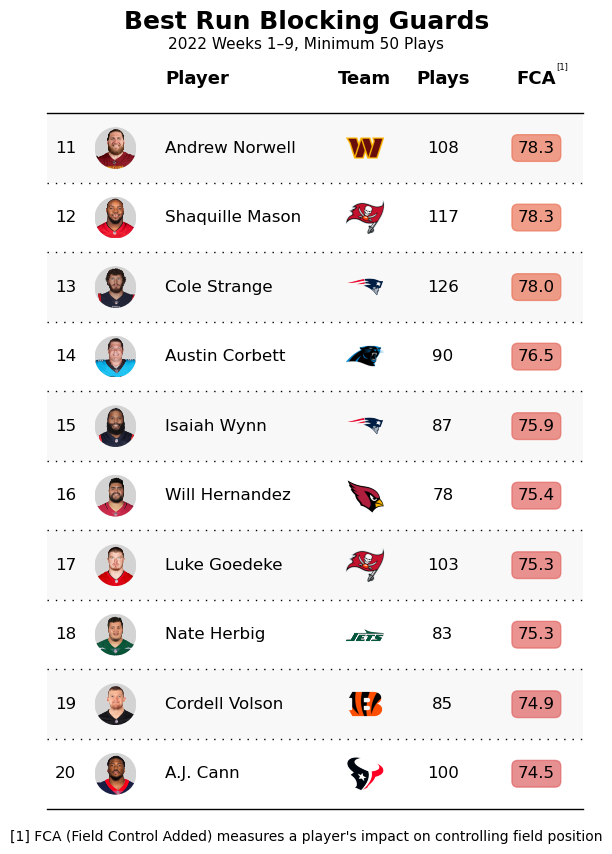

In [14]:
import matplotlib
from plottable import ColumnDefinition, Table
from plottable.cmap import normed_cmap
import requests
from io import BytesIO
from PIL import Image

guards_t20 = (
    guards
    [guards['N Plays'] >= 50]
    .sort_values('FCA', ascending=False)
    .reset_index(drop=True)
    .head(10)
)

guards_t20.insert(0, "Rank", range(1, len(guards_t20) + 1))
guards_t20.set_index('Rank', inplace=True)

HEADSHOT_DIR = join(DATA_DIR, 'images', 'headshots')
os.makedirs(HEADSHOT_DIR, exist_ok=True)

def download_image(url, save_path, playername, team):
    try:
        filename = f"{playername.replace(' ', '_').replace('.', '')}_{team}.png"
        filepath = os.path.join(save_path, filename)

        # Skip if already exists
        if os.path.exists(filepath):
            print(f"Skipped {filepath} - already exists")
            return

        # Download
        response = requests.get(url, stream=True)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content)).convert("RGBA")

        # Get background color (top-left pixel)
        datas = img.getdata()
        new_data = []
        bg_color = datas[0]  # likely green screen background

        for item in datas:
            # Match background color exactly (RGB only)
            if item[:3] == bg_color[:3]:
                new_data.append((255, 255, 255, 0))  # transparent
            else:
                new_data.append(item)

        img.putdata(new_data)
        img.save(filepath, format="PNG")
        print(f"Downloaded and saved transparent image to {filepath}")

    except Exception as e:
        print(f"Error downloading image from {url}: {e}")


for row in guards_t20.itertuples():
    download_image(
        row.headshot_url,
        HEADSHOT_DIR,
        row.Player,
        row.team
    )

guards_t20['headshot_path'] = guards_t20.apply(
    lambda row: os.path.join(
        HEADSHOT_DIR,
        f"{row.Player.replace(' ', '_').replace('.','')}_{row.team}.png"
    ),
    axis=1
)

teams = nfl.import_team_desc()

TEAM_LOGO_DIR = join(DATA_DIR, 'images', 'team_logos')
os.makedirs(TEAM_LOGO_DIR, exist_ok=True)
for row in teams.itertuples():
    download_image(
        row.team_logo_espn,
        TEAM_LOGO_DIR,
        row.team_abbr,
        ""
    )

guards_t20['team_logo_path'] = guards_t20.apply(
    lambda row: os.path.join(
        TEAM_LOGO_DIR,
        f"{row.team}_.png"
    ),
    axis=1
)

col_defs = [
    ColumnDefinition(
        name="Rank",
        title="",
        textprops={"ha": "center", "weight": "normal"},
        width=0.3,
    ),
    ColumnDefinition(
        name="headshot_path",
        title="",
        textprops={"ha": "right"},
        width=.5,
        plot_fn=lambda ax, val: circled_image(
            ax, 
            val,
            bg_circle=True,
            zoom=1.0,
        )
    ),
    ColumnDefinition(
        name="Player",
        textprops={"ha": "left", "weight": "normal"},
        width=1.5,
    ),
    ColumnDefinition(
        name="team_logo_path",
        title="Team",
        textprops={"ha": "center"},
        width=0.5,
        plot_fn=lambda ax, val: regular_image(
            ax, 
            val,
            zoom=0.8,        
        )
    ),
    ColumnDefinition(
        name="N Plays",
        title="Plays",
        textprops={"ha": "center"},
        width=0.75,
    ),
    ColumnDefinition(
        name="FCA",
        title="FCA",
        textprops={
            "ha": "center",
            "bbox": {"boxstyle": "round,pad=0.35", "edgecolor": "none", "alpha": 0.7},
        },
        formatter=lambda x: f"{x:.1f}",
        cmap=normed_cmap(guards["FCA"], cmap=matplotlib.cm.plasma, num_stds=2.5),
        width=0.75,
    )
]

# Figure setup
plt.rcParams["font.family"] = ["DejaVu Sans"]
fig, ax = plt.subplots(figsize=(7, 10))

cols = ["headshot_path", "Player", "team_logo_path", "N Plays", "FCA"]

table = Table(
    guards_t20[cols],
    column_definitions=col_defs,
    row_dividers=True,
    footer_divider=True,
    ax=ax,
    textprops={"fontsize": 12, "weight": "normal"},
    row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
    col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
    column_border_kw={"linewidth": 1, "linestyle": "-"},
    even_row_color="#f8f8f8",  # Light gray for even rows
)
# Make only the column headers bold (and optionally tweak size)
for cell in table.col_label_row.cells:
    if hasattr(cell, "text") and cell.text is not None:
        cell.text.set_fontweight("bold")
        cell.text.set_fontsize(13)

# Title & footer
fig.suptitle(
    "Best Run Blocking Guards",
    fontsize=18,
    fontweight="bold",
    y=0.9,
    ha="center", va="center",
)

# Subtitle
fig.text(
    0.5, 0.878,  # Position just below main title
    "2022 Weeks 1–9, Minimum 50 Plays",
    fontsize=11,
    ha="center", va="center"
)

fig.text(
    0.5, 0.085,
    "[1] FCA (Field Control Added) measures a player's impact on controlling field position",
    ha="center", va="center", fontsize=10
)

fig.text(
    0.865, 0.855,
    "[1]",
    ha="center", va="center", fontsize=6
)

# save image to ../results/oline_run_blocking_grades/guards_t20.png
os.makedirs('../results/oline_run_blocking_grades', exist_ok=True)
plt.savefig('../results/oline_run_blocking_grades/guards_t10.png', bbox_inches='tight', dpi=300)

plt.show()
import matplotlib
from plottable import ColumnDefinition, Table
from plottable.cmap import normed_cmap
import requests
from io import BytesIO
from PIL import Image

guards_t20 = (
    guards
    [guards['N Plays'] >= 50]
    .sort_values('FCA', ascending=False)
    .reset_index(drop=True)
    .iloc[10:20]  # Get the next 10 after the top 10
)

guards_t20.insert(0, "Rank", range(11, 21))
guards_t20.set_index('Rank', inplace=True)

HEADSHOT_DIR = join(DATA_DIR, 'images', 'headshots')
os.makedirs(HEADSHOT_DIR, exist_ok=True)

def download_image(url, save_path, playername, team):
    try:
        filename = f"{playername.replace(' ', '_').replace('.', '')}_{team}.png"
        filepath = os.path.join(save_path, filename)

        # Skip if already exists
        if os.path.exists(filepath):
            print(f"Skipped {filepath} - already exists")
            return

        # Download
        response = requests.get(url, stream=True)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content)).convert("RGBA")

        # Get background color (top-left pixel)
        datas = img.getdata()
        new_data = []
        bg_color = datas[0]  # likely green screen background

        for item in datas:
            # Match background color exactly (RGB only)
            if item[:3] == bg_color[:3]:
                new_data.append((255, 255, 255, 0))  # transparent
            else:
                new_data.append(item)

        img.putdata(new_data)
        img.save(filepath, format="PNG")
        print(f"Downloaded and saved transparent image to {filepath}")

    except Exception as e:
        print(f"Error downloading image from {url}: {e}")


for row in guards_t20.itertuples():
    download_image(
        row.headshot_url,
        HEADSHOT_DIR,
        row.Player,
        row.team
    )

guards_t20['headshot_path'] = guards_t20.apply(
    lambda row: os.path.join(
        HEADSHOT_DIR,
        f"{row.Player.replace(' ', '_').replace('.','')}_{row.team}.png"
    ),
    axis=1
)

teams = nfl.import_team_desc()

TEAM_LOGO_DIR = join(DATA_DIR, 'images', 'team_logos')
os.makedirs(TEAM_LOGO_DIR, exist_ok=True)
for row in teams.itertuples():
    download_image(
        row.team_logo_espn,
        TEAM_LOGO_DIR,
        row.team_abbr,
        ""
    )

guards_t20['team_logo_path'] = guards_t20.apply(
    lambda row: os.path.join(
        TEAM_LOGO_DIR,
        f"{row.team}_.png"
    ),
    axis=1
)

col_defs = [
    ColumnDefinition(
        name="Rank",
        title="",
        textprops={"ha": "center", "weight": "normal"},
        width=0.3,
    ),
    ColumnDefinition(
        name="headshot_path",
        title="",
        textprops={"ha": "right"},
        width=.5,
        plot_fn=lambda ax, val: circled_image(
            ax, 
            val,
            bg_circle=True,
            zoom=1.0,
        )
    ),
    ColumnDefinition(
        name="Player",
        textprops={"ha": "left", "weight": "normal"},
        width=1.5,
    ),
    ColumnDefinition(
        name="team_logo_path",
        title="Team",
        textprops={"ha": "center"},
        width=0.5,
        plot_fn=lambda ax, val: regular_image(
            ax, 
            val,
            zoom=0.8,        
        )
    ),
    ColumnDefinition(
        name="N Plays",
        title="Plays",
        textprops={"ha": "center"},
        width=0.75,
    ),
    ColumnDefinition(
        name="FCA",
        title="FCA",
        textprops={
            "ha": "center",
            "bbox": {"boxstyle": "round,pad=0.35", "edgecolor": "none", "alpha": 0.7},
        },
        formatter=lambda x: f"{x:.1f}",
        cmap=normed_cmap(guards["FCA"], cmap=matplotlib.cm.plasma, num_stds=2.5),
        width=0.75,
    )
]

# Figure setup
plt.rcParams["font.family"] = ["DejaVu Sans"]
fig, ax = plt.subplots(figsize=(7, 10))

cols = ["headshot_path", "Player", "team_logo_path", "N Plays", "FCA"]

table = Table(
    guards_t20[cols],
    column_definitions=col_defs,
    row_dividers=True,
    footer_divider=True,
    ax=ax,
    textprops={"fontsize": 12, "weight": "normal"},
    row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
    col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
    column_border_kw={"linewidth": 1, "linestyle": "-"},
    even_row_color="#f8f8f8",  # Light gray for even rows
)
# Make only the column headers bold (and optionally tweak size)
for cell in table.col_label_row.cells:
    if hasattr(cell, "text") and cell.text is not None:
        cell.text.set_fontweight("bold")
        cell.text.set_fontsize(13)

# Title & footer
fig.suptitle(
    "Best Run Blocking Guards",
    fontsize=18,
    fontweight="bold",
    y=0.9,
    ha="center", va="center",
)

# Subtitle
fig.text(
    0.5, 0.878,  # Position just below main title
    "2022 Weeks 1–9, Minimum 50 Plays",
    fontsize=11,
    ha="center", va="center"
)

fig.text(
    0.5, 0.085,
    "[1] FCA (Field Control Added) measures a player's impact on controlling field position",
    ha="center", va="center", fontsize=10
)

fig.text(
    0.865, 0.855,
    "[1]",
    ha="center", va="center", fontsize=6
)

# save image to ../results/oline_run_blocking_grades/guards_t20.png
os.makedirs('../results/oline_run_blocking_grades', exist_ok=True)
plt.savefig('../results/oline_run_blocking_grades/guards_t10_20.png', bbox_inches='tight', dpi=300)

plt.show()

# Centers

Skipped ../data/images/headshots/Ethan_Pocic_CLE.png - already exists
Skipped ../data/images/headshots/Ryan_Kelly_IND.png - already exists
Skipped ../data/images/headshots/Jon_Feliciano_NYG.png - already exists
Skipped ../data/images/headshots/Creed_Humphrey_KC.png - already exists
Skipped ../data/images/headshots/Ted_Karras_CIN.png - already exists
Skipped ../data/images/headshots/Pat_Elflein_CAR.png - already exists
Skipped ../data/images/headshots/Jason_Kelce_PHI.png - already exists
Skipped ../data/images/headshots/Mason_Cole_PIT.png - already exists
Skipped ../data/images/headshots/Scott_Quessenberry_HOU.png - already exists
Skipped ../data/images/headshots/Danny_Pinter_IND.png - already exists
Skipped ../data/images/team_logos/ARI_.png - already exists
Skipped ../data/images/team_logos/ATL_.png - already exists
Skipped ../data/images/team_logos/BAL_.png - already exists
Skipped ../data/images/team_logos/BUF_.png - already exists
Skipped ../data/images/team_logos/CAR_.png - alread

/Users/lukeneuendorf/miniforge3/envs/nfl-oline/lib/python3.11/site-packages/plottable/table.py:543: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  cell.text.set_bbox(


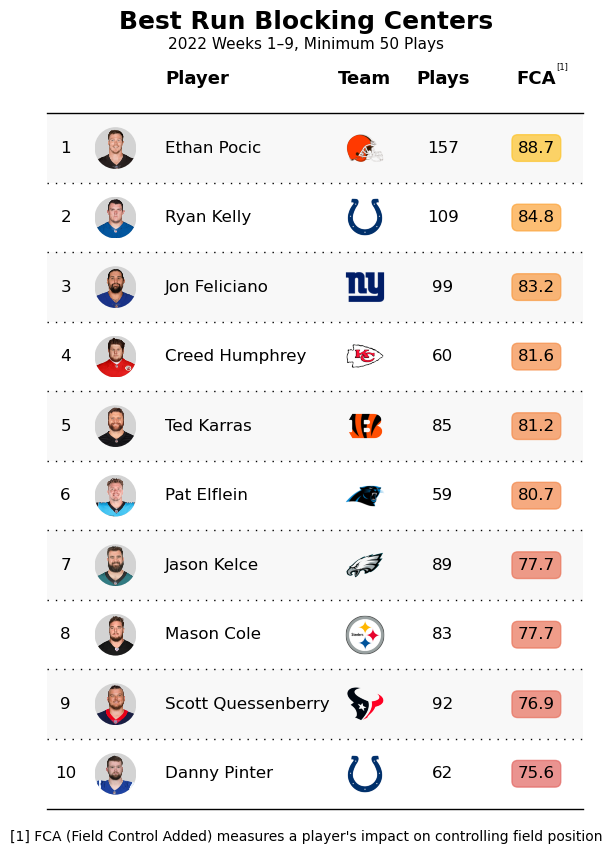

Skipped ../data/images/headshots/Tyler_Biadasz_DAL.png - already exists
Skipped ../data/images/headshots/Tyler_Larsen_WAS.png - already exists
Skipped ../data/images/headshots/Drew_Dalman_ATL.png - already exists
Skipped ../data/images/headshots/David_Andrews_NE.png - already exists
Skipped ../data/images/headshots/Erik_McCoy_NO.png - already exists
Skipped ../data/images/headshots/Robert_Hainsey_TB.png - already exists
Skipped ../data/images/headshots/Frank_Ragnow_DET.png - already exists
Skipped ../data/images/headshots/Evan_Brown_DET.png - already exists
Skipped ../data/images/headshots/Ben_Jones_TEN.png - already exists
Skipped ../data/images/headshots/Josh_Myers_GB.png - already exists
Skipped ../data/images/team_logos/ARI_.png - already exists
Skipped ../data/images/team_logos/ATL_.png - already exists
Skipped ../data/images/team_logos/BAL_.png - already exists
Skipped ../data/images/team_logos/BUF_.png - already exists
Skipped ../data/images/team_logos/CAR_.png - already exists


/Users/lukeneuendorf/miniforge3/envs/nfl-oline/lib/python3.11/site-packages/plottable/table.py:543: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  cell.text.set_bbox(


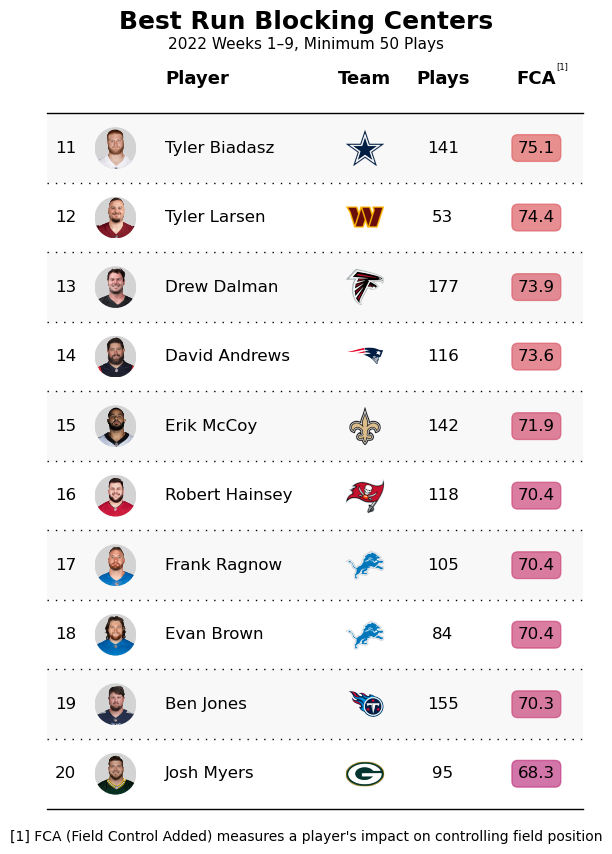

In [13]:
import matplotlib
from plottable import ColumnDefinition, Table
from plottable.cmap import normed_cmap
import requests
from io import BytesIO
from PIL import Image

centers_t20 = (
    centers
    [centers['N Plays'] >= 50]
    .sort_values('FCA', ascending=False)
    .reset_index(drop=True)
    .head(10)
)

centers_t20.insert(0, "Rank", range(1, len(centers_t20) + 1))
centers_t20.set_index('Rank', inplace=True)

HEADSHOT_DIR = join(DATA_DIR, 'images', 'headshots')
os.makedirs(HEADSHOT_DIR, exist_ok=True)

def download_image(url, save_path, playername, team):
    try:
        filename = f"{playername.replace(' ', '_').replace('.', '')}_{team}.png"
        filepath = os.path.join(save_path, filename)

        # Skip if already exists
        if os.path.exists(filepath):
            print(f"Skipped {filepath} - already exists")
            return

        # Download
        response = requests.get(url, stream=True)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content)).convert("RGBA")

        # Get background color (top-left pixel)
        datas = img.getdata()
        new_data = []
        bg_color = datas[0]  # likely green screen background

        for item in datas:
            # Match background color exactly (RGB only)
            if item[:3] == bg_color[:3]:
                new_data.append((255, 255, 255, 0))  # transparent
            else:
                new_data.append(item)

        img.putdata(new_data)
        img.save(filepath, format="PNG")
        print(f"Downloaded and saved transparent image to {filepath}")

    except Exception as e:
        print(f"Error downloading image from {url}: {e}")


for row in centers_t20.itertuples():
    download_image(
        row.headshot_url,
        HEADSHOT_DIR,
        row.Player,
        row.team
    )

centers_t20['headshot_path'] = centers_t20.apply(
    lambda row: os.path.join(
        HEADSHOT_DIR,
        f"{row.Player.replace(' ', '_').replace('.','')}_{row.team}.png"
    ),
    axis=1
)

teams = nfl.import_team_desc()

TEAM_LOGO_DIR = join(DATA_DIR, 'images', 'team_logos')
os.makedirs(TEAM_LOGO_DIR, exist_ok=True)
for row in teams.itertuples():
    download_image(
        row.team_logo_espn,
        TEAM_LOGO_DIR,
        row.team_abbr,
        ""
    )

centers_t20['team_logo_path'] = centers_t20.apply(
    lambda row: os.path.join(
        TEAM_LOGO_DIR,
        f"{row.team}_.png"
    ),
    axis=1
)

col_defs = [
    ColumnDefinition(
        name="Rank",
        title="",
        textprops={"ha": "center", "weight": "normal"},
        width=0.3,
    ),
    ColumnDefinition(
        name="headshot_path",
        title="",
        textprops={"ha": "right"},
        width=.5,
        plot_fn=lambda ax, val: circled_image(
            ax, 
            val,
            bg_circle=True,
            zoom=1.0,
        )
    ),
    ColumnDefinition(
        name="Player",
        textprops={"ha": "left", "weight": "normal"},
        width=1.5,
    ),
    ColumnDefinition(
        name="team_logo_path",
        title="Team",
        textprops={"ha": "center"},
        width=0.5,
        plot_fn=lambda ax, val: regular_image(
            ax, 
            val,
            zoom=0.8,        
        )
    ),
    ColumnDefinition(
        name="N Plays",
        title="Plays",
        textprops={"ha": "center"},
        width=0.75,
    ),
    ColumnDefinition(
        name="FCA",
        title="FCA",
        textprops={
            "ha": "center",
            "bbox": {"boxstyle": "round,pad=0.35", "edgecolor": "none", "alpha": 0.7},
        },
        formatter=lambda x: f"{x:.1f}",
        cmap=normed_cmap(centers["FCA"], cmap=matplotlib.cm.plasma, num_stds=2.5),
        width=0.75,
    )
]

# Figure setup
plt.rcParams["font.family"] = ["DejaVu Sans"]
fig, ax = plt.subplots(figsize=(7, 10))

cols = ["headshot_path", "Player", "team_logo_path", "N Plays", "FCA"]

table = Table(
    centers_t20[cols],
    column_definitions=col_defs,
    row_dividers=True,
    footer_divider=True,
    ax=ax,
    textprops={"fontsize": 12, "weight": "normal"},
    row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
    col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
    column_border_kw={"linewidth": 1, "linestyle": "-"},
    even_row_color="#f8f8f8",  # Light gray for even rows
)
# Make only the column headers bold (and optionally tweak size)
for cell in table.col_label_row.cells:
    if hasattr(cell, "text") and cell.text is not None:
        cell.text.set_fontweight("bold")
        cell.text.set_fontsize(13)

# Title & footer
fig.suptitle(
    "Best Run Blocking Centers",
    fontsize=18,
    fontweight="bold",
    y=0.9,
    ha="center", va="center",
)

# Subtitle
fig.text(
    0.5, 0.878,  # Position just below main title
    "2022 Weeks 1–9, Minimum 50 Plays",
    fontsize=11,
    ha="center", va="center"
)

fig.text(
    0.5, 0.085,
    "[1] FCA (Field Control Added) measures a player's impact on controlling field position",
    ha="center", va="center", fontsize=10
)

fig.text(
    0.865, 0.855,
    "[1]",
    ha="center", va="center", fontsize=6
)

# save image to ../results/oline_run_blocking_grades/centers_t20.png
os.makedirs('../results/oline_run_blocking_grades', exist_ok=True)
plt.savefig('../results/oline_run_blocking_grades/centers_t10.png', bbox_inches='tight', dpi=300)

plt.show()
import matplotlib
from plottable import ColumnDefinition, Table
from plottable.cmap import normed_cmap
import requests
from io import BytesIO
from PIL import Image

centers_t20 = (
    centers
    [centers['N Plays'] >= 50]
    .sort_values('FCA', ascending=False)
    .reset_index(drop=True)
    .iloc[10:20]  # Get the next 10 after the top 10
)

centers_t20.insert(0, "Rank", range(11, 21))
centers_t20.set_index('Rank', inplace=True)

HEADSHOT_DIR = join(DATA_DIR, 'images', 'headshots')
os.makedirs(HEADSHOT_DIR, exist_ok=True)

def download_image(url, save_path, playername, team):
    try:
        filename = f"{playername.replace(' ', '_').replace('.', '')}_{team}.png"
        filepath = os.path.join(save_path, filename)

        # Skip if already exists
        if os.path.exists(filepath):
            print(f"Skipped {filepath} - already exists")
            return

        # Download
        response = requests.get(url, stream=True)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content)).convert("RGBA")

        # Get background color (top-left pixel)
        datas = img.getdata()
        new_data = []
        bg_color = datas[0]  # likely green screen background

        for item in datas:
            # Match background color exactly (RGB only)
            if item[:3] == bg_color[:3]:
                new_data.append((255, 255, 255, 0))  # transparent
            else:
                new_data.append(item)

        img.putdata(new_data)
        img.save(filepath, format="PNG")
        print(f"Downloaded and saved transparent image to {filepath}")

    except Exception as e:
        print(f"Error downloading image from {url}: {e}")


for row in centers_t20.itertuples():
    download_image(
        row.headshot_url,
        HEADSHOT_DIR,
        row.Player,
        row.team
    )

centers_t20['headshot_path'] = centers_t20.apply(
    lambda row: os.path.join(
        HEADSHOT_DIR,
        f"{row.Player.replace(' ', '_').replace('.','')}_{row.team}.png"
    ),
    axis=1
)

teams = nfl.import_team_desc()

TEAM_LOGO_DIR = join(DATA_DIR, 'images', 'team_logos')
os.makedirs(TEAM_LOGO_DIR, exist_ok=True)
for row in teams.itertuples():
    download_image(
        row.team_logo_espn,
        TEAM_LOGO_DIR,
        row.team_abbr,
        ""
    )

centers_t20['team_logo_path'] = centers_t20.apply(
    lambda row: os.path.join(
        TEAM_LOGO_DIR,
        f"{row.team}_.png"
    ),
    axis=1
)

col_defs = [
    ColumnDefinition(
        name="Rank",
        title="",
        textprops={"ha": "center", "weight": "normal"},
        width=0.3,
    ),
    ColumnDefinition(
        name="headshot_path",
        title="",
        textprops={"ha": "right"},
        width=.5,
        plot_fn=lambda ax, val: circled_image(
            ax, 
            val,
            bg_circle=True,
            zoom=1.0,
        )
    ),
    ColumnDefinition(
        name="Player",
        textprops={"ha": "left", "weight": "normal"},
        width=1.5,
    ),
    ColumnDefinition(
        name="team_logo_path",
        title="Team",
        textprops={"ha": "center"},
        width=0.5,
        plot_fn=lambda ax, val: regular_image(
            ax, 
            val,
            zoom=0.8,        
        )
    ),
    ColumnDefinition(
        name="N Plays",
        title="Plays",
        textprops={"ha": "center"},
        width=0.75,
    ),
    ColumnDefinition(
        name="FCA",
        title="FCA",
        textprops={
            "ha": "center",
            "bbox": {"boxstyle": "round,pad=0.35", "edgecolor": "none", "alpha": 0.7},
        },
        formatter=lambda x: f"{x:.1f}",
        cmap=normed_cmap(centers["FCA"], cmap=matplotlib.cm.plasma, num_stds=2.5),
        width=0.75,
    )
]

# Figure setup
plt.rcParams["font.family"] = ["DejaVu Sans"]
fig, ax = plt.subplots(figsize=(7, 10))

cols = ["headshot_path", "Player", "team_logo_path", "N Plays", "FCA"]

table = Table(
    centers_t20[cols],
    column_definitions=col_defs,
    row_dividers=True,
    footer_divider=True,
    ax=ax,
    textprops={"fontsize": 12, "weight": "normal"},
    row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
    col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
    column_border_kw={"linewidth": 1, "linestyle": "-"},
    even_row_color="#f8f8f8",  # Light gray for even rows
)
# Make only the column headers bold (and optionally tweak size)
for cell in table.col_label_row.cells:
    if hasattr(cell, "text") and cell.text is not None:
        cell.text.set_fontweight("bold")
        cell.text.set_fontsize(13)

# Title & footer
fig.suptitle(
    "Best Run Blocking Centers",
    fontsize=18,
    fontweight="bold",
    y=0.9,
    ha="center", va="center",
)

# Subtitle
fig.text(
    0.5, 0.878,  # Position just below main title
    "2022 Weeks 1–9, Minimum 50 Plays",
    fontsize=11,
    ha="center", va="center"
)

fig.text(
    0.5, 0.085,
    "[1] FCA (Field Control Added) measures a player's impact on controlling field position",
    ha="center", va="center", fontsize=10
)

fig.text(
    0.865, 0.855,
    "[1]",
    ha="center", va="center", fontsize=6
)

# save image to ../results/oline_run_blocking_grades/centers_t20.png
os.makedirs('../results/oline_run_blocking_grades', exist_ok=True)
plt.savefig('../results/oline_run_blocking_grades/centers_t10_20.png', bbox_inches='tight', dpi=300)

plt.show()

,game_play_id,player_id,position,fc_attribution,baseline_fc
0,2022090800_101,35472.0,LG,0.009602,0.447097
1,2022090800_101,42392.0,C,0.015155,0.447097
2,2022090800_101,44875.0,LT,0.021471,0.447097
3,2022090800_101,48512.0,RG,0.021618,0.447097
4,2022090800_101,53522.0,RT,0.035633,0.447097


In [253]:
df_flat = attrib_df.pivot(index='game_play_id', columns='position', values='fc_attribution').reset_index()

# Rename the columns to include '_fc_attribution'
df_flat = df_flat.rename(columns=lambda x: f"{x.lower()}_fc_attribution" if x != 'game_play_id' else x)

# If you want to keep baseline_fc as well (assuming it's the same for all players in the same play):
baseline_fc = attrib_df[['game_play_id', 'baseline_fc']].drop_duplicates()
cols = ['lt_fc_attribution', 'lg_fc_attribution', 'c_fc_attribution', 
        'rg_fc_attribution', 'rt_fc_attribution', 'baseline_fc']

df_flat = (
    df_flat.merge(baseline_fc, on='game_play_id')
    [['game_play_id'] + cols]
    .merge(
        plays[['game_play_id', 'possession_team', 'yards_to_go', 'absolute_yardline_number', 'rush_location_type', 'down', 'yards_gained']],
        on='game_play_id',
        how='left'
    )
    .assign(
        line_yards=lambda x: np.where(
            x.yards_gained < 5,
            x.yards_gained,
            np.where(
                x.yards_gained < 10,
                4 + 0.5 * (x.yards_gained - 4),
                7
            )
        )
    )
    .assign(
        line_yards_20 = lambda x: x.line_yards * 2.0,
        line_yards_18 = lambda x: x.line_yards * 1.8,
        line_yards_16 = lambda x: x.line_yards * 1.6,
        line_yards_15 = lambda x: x.line_yards * 1.5,
        line_yards_14 = lambda x: x.line_yards * 1.4,
        line_yards_12 = lambda x: x.line_yards * 1.2,
        line_yards_08 = lambda x: x.line_yards * 0.8,
        line_yards_06 = lambda x: x.line_yards * 0.6,
    )
    .assign(
        adjusted_line_yards = lambda x: np.where(
            x.absolute_yardline_number >= 95,  # within 5 yards of end zone
            x.line_yards_14,
            np.where(
                x.down.isin([3,4]) & (x.yards_to_go <= 2),
                x.line_yards_12,
                np.where(
                    x.down.isin([2,3,4]) & (x.yards_to_go >= 8),
                    x.line_yards_08,
                    x.line_yards
                )
            )
        )
    )
)

In [254]:
df_flat.rush_location_type.value_counts()

INSIDE_RIGHT     1085
INSIDE_LEFT      1079
OUTSIDE_RIGHT     772
OUTSIDE_LEFT      687
Name: rush_location_type, dtype: int64

In [260]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm 
import statsmodels.formula.api as smf

df_flat['rush_location'] = np.where(
    df_flat['rush_location_type'].isin(['INSIDE_LEFT','OUTSIDE_LEFT']),
    'left',
    np.where(
        df_flat['rush_location_type'].isin(['INSIDE_RIGHT','OUTSIDE_RIGHT']),
        'right',
        'unknown'
    )
)

df_flat['lt_left'] = df_flat['lt_fc_attribution'] * (df_flat['rush_location'] == 'left')
df_flat['lg_left'] = df_flat['lg_fc_attribution'] * (df_flat['rush_location'] == 'left')
df_flat['rt_right'] = df_flat['rt_fc_attribution'] * (df_flat['rush_location'] == 'right')
df_flat['rg_right'] = df_flat['rg_fc_attribution'] * (df_flat['rush_location'] == 'right')

model = smf.ols(
    'adjusted_line_yards ~ lt_left + lg_left + c_fc_attribution + rg_right + rt_right + yards_to_go + absolute_yardline_number',
    data=df_flat
).fit()

print(model.summary())


                             OLS Regression Results                            
Dep. Variable:     adjusted_line_yards   R-squared:                       0.014
Model:                             OLS   Adj. R-squared:                  0.012
Method:                  Least Squares   F-statistic:                     7.154
Date:                 Fri, 22 Aug 2025   Prob (F-statistic):           1.60e-08
Time:                         19:39:17   Log-Likelihood:                -8789.0
No. Observations:                 3623   AIC:                         1.759e+04
Df Residuals:                     3615   BIC:                         1.764e+04
Df Model:                            7                                         
Covariance Type:             nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept     

In [99]:
df_flat['ol_sum'] = df_flat[['lt_fc_attribution','lg_fc_attribution','c_fc_attribution','rg_fc_attribution','rt_fc_attribution']].sum(axis=1)
df_flat[['ol_sum','yards_gained_first_5']].corr(method='spearman')

,ol_sum,yards_gained_first_5
ol_sum,1.000000,0.048857
yards_gained_first_5,0.048857,1.000000


<Axes: xlabel='ol_quantile', ylabel='yards_gained_first_5'>

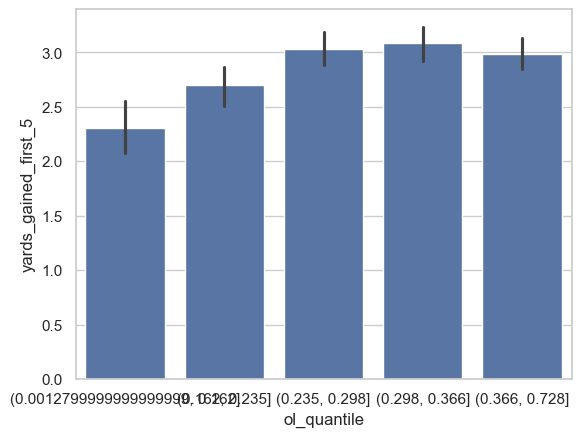

In [100]:
df_flat['ol_quantile'] = pd.qcut(df_flat['ol_sum'], 5)
sns.barplot(x='ol_quantile', y='yards_gained_first_5', data=df_flat)

In [102]:
df_flat['success_5'] = (df_flat['yards_gained_first_5'] >= 5).astype(int)
model = smf.logit('success_5 ~ lt_fc_attribution + lg_fc_attribution + c_fc_attribution + rg_fc_attribution + rt_fc_attribution', data=df_flat).fit()

print(model.summary())

Optimization terminated successfully.
         Current function value: 0.661774
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:              success_5   No. Observations:                 3275
Model:                          Logit   Df Residuals:                     3269
Method:                           MLE   Df Model:                            5
Date:                Fri, 22 Aug 2025   Pseudo R-squ.:                0.001977
Time:                        00:26:59   Log-Likelihood:                -2167.3
converged:                       True   LL-Null:                       -2171.6
Covariance Type:            nonrobust   LLR p-value:                    0.1268
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.2850      0.091     -3.145      0.002      -0.463      -0.107
lt_fc_at

In [103]:
import statsmodels.formula.api as smf
model = smf.mixedlm("yards_gained_first_5 ~ lt_fc_attribution + lg_fc_attribution + c_fc_attribution + rg_fc_attribution + rt_fc_attribution", 
                    df_flat, 
                    groups=df_flat["game_id"])
result = model.fit()

KeyError: 'game_id'

In [104]:
import statsmodels.formula.api as smf

# If game_play_id encodes the game (or you have another column like 'game_date'), use that
model = smf.mixedlm(
    "yards_gained_first_5 ~ lt_fc_attribution + lg_fc_attribution + c_fc_attribution + rg_fc_attribution + rt_fc_attribution",
    df_flat,
    groups=df_flat["game_play_id"]  # or a real game-level column if you have one
)
result = model.fit()
print(result.summary())


              Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: yards_gained_first_5
No. Observations: 3275    Method:             REML                
No. Groups:       3275    Scale:              2.6818              
Min. group size:  1       Log-Likelihood:     -7390.7755          
Max. group size:  1       Converged:          Yes                 
Mean group size:  1.0                                             
-------------------------------------------------------------------
                     Coef.  Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------------
Intercept            2.249     0.100  22.418  0.000   2.052   2.446
lt_fc_attribution    2.596     1.376   1.887  0.059  -0.100   5.293
lg_fc_attribution    0.787     1.327   0.593  0.553  -1.814   3.387
c_fc_attribution     2.520     1.170   2.153  0.031   0.226   4.814
rg_fc_attribution    2.497     1.142   2.187  0.029   0.259   4.735
rt

/Users/lukeneuendorf/miniforge3/envs/nfl-oline/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [105]:
df_flat.head()

,game_play_id,lt_fc_attribution,lg_fc_attribution,c_fc_attribution,rg_fc_attribution,rt_fc_attribution,baseline_fc,yards_to_go,yards_gained,rush_location_type,absolute_yardline_number,yards_gained_first_5,rush_location,lt_left,lg_left,rt_right,rg_right,predicted_yards,ol_sum,ol_quantile,success_5
0,2022090800_101,0.021471,0.009602,0.015155,0.021618,0.035633,0.447097,10,7,INSIDE_RIGHT,48,5,right,0.000000,0.000000,0.035633,0.021618,2.591984,0.103480,"(0.0012799999999999999, 0.162]",1
1,2022090800_1187,0.110851,0.104601,0.082128,0.090620,0.069560,0.521216,10,4,INSIDE_LEFT,50,4,left,0.110851,0.104601,0.000000,0.000000,3.076126,0.457760,"(0.366, 0.728]",0
2,2022090800_1385,0.024059,0.011771,0.039129,0.019150,0.002786,0.452042,10,18,INSIDE_LEFT,85,5,left,0.024059,0.011771,0.000000,0.000000,2.306840,0.096896,"(0.0012799999999999999, 0.162]",1
4,2022090800_1736,0.076925,0.132584,0.071048,0.095670,0.043092,0.583060,1,0,INSIDE_RIGHT,79,0,right,0.000000,0.000000,0.043092,0.095670,3.066451,0.419319,"(0.366, 0.728]",0
5,2022090800_191,0.002239,0.024868,0.017721,0.068481,0.016099,0.416422,10,1,OUTSIDE_RIGHT,75,1,right,0.000000,0.000000,0.016099,0.068481,2.060782,0.129407,"(0.0012799999999999999, 0.162]",0


In [113]:
df_flat['game_play_id'].str.split('_')[0]

['2022090800', '101']

In [114]:
df_flat.shape

(3275, 21)

In [112]:
df_flat[~df_flat.game_play_id.str.contains('_')]

,game_play_id,lt_fc_attribution,lg_fc_attribution,c_fc_attribution,rg_fc_attribution,rt_fc_attribution,baseline_fc,yards_to_go,yards_gained,rush_location_type,absolute_yardline_number,yards_gained_first_5,rush_location,lt_left,lg_left,rt_right,rg_right,predicted_yards,ol_sum,ol_quantile,success_5


In [ ]:
import statsmodels.formula.api as smf
df_flat = df_flat.assign(
    game_id = lambda x: x['game_play_id'].str.split('_').str[0]
)
model = smf.mixedlm(
    "yards_gained_first_5 ~ lt_fc_attribution + lg_fc_attribution + c_fc_attribution + rg_fc_attribution + rt_fc_attribution",
    df_flat,
    groups=df_flat['game_id']  # multiple plays per game

result = model.fit()
print(result.summary())
# pritn r squared
print(f"R-squared: {np.corrcoef(df_flat['yards_gained_first_5'], result.fittedvalues)[0, 1]**2}")

/Users/lukeneuendorf/miniforge3/envs/nfl-oline/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lukeneuendorf/miniforge3/envs/nfl-oline/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/lukeneuendorf/miniforge3/envs/nfl-oline/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lukeneuendorf/miniforge3/envs/nfl-oline/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(


              Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: yards_gained_first_5
No. Observations: 3275    Method:             REML                
No. Groups:       123     Scale:              5.3475              
Min. group size:  7       Log-Likelihood:     -7390.5216          
Max. group size:  41      Converged:          No                  
Mean group size:  26.6                                            
-------------------------------------------------------------------
                     Coef.  Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------------
Intercept            2.245     0.103  21.778  0.000   2.043   2.447
lt_fc_attribution    2.643     1.424   1.857  0.063  -0.147   5.433
lg_fc_attribution    0.779     1.454   0.535  0.592  -2.072   3.629
c_fc_attribution     2.524     1.443   1.750  0.080  -0.304   5.352
rg_fc_attribution    2.518     1.443   1.745  0.081  -0.311   5.348
rt

/Users/lukeneuendorf/miniforge3/envs/nfl-oline/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lukeneuendorf/miniforge3/envs/nfl-oline/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/lukeneuendorf/miniforge3/envs/nfl-oline/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 2.210564
  warnings.warn(msg, ConvergenceWarning)


In [120]:
plays.shape

(3623, 27)

In [121]:
plays.head()

,game_play_id,game_id,play_id,play_description,quarter,down,yards_to_go,possession_team,defensive_team,game_clock,pre_snap_home_score,pre_snap_visitor_score,absolute_yardline_number,pre_snap_home_team_win_probability,pre_snap_visitor_team_win_probability,expected_points,offense_formation,receiver_alignment,play_clock_at_snap,rush_location_type,yards_gained,home_team_win_probability_added,visitor_team_win_probility_added,expected_points_added,pff_run_concept_primary,pff_pass_coverage,pff_man_zone
0,2022100205_2314,2022100205,2314,(14:15) Ja.Williams up the middle to DET 32 fo...,3,2,6,DET,SEA,14:15,15,31,39,0.138289,0.861711,1.066931,SINGLEBACK,3x1,15.0,INSIDE_RIGHT,3,-0.024210,0.024210,-0.442517,MAN,Cover 6-Left,Zone
1,2022102306_3240,2022102306,3240,(12:55) (Shotgun) A.Dillon left tackle to WAS ...,4,2,10,GB,WAS,12:55,20,14,64,0.630746,0.369254,2.416086,SHOTGUN,3x1,4.0,INSIDE_LEFT,0,0.053308,-0.053308,-0.962012,PULL LEAD,Cover-6 Right,Zone
2,2022101601_2344,2022101601,2344,(10:13) (No Huddle) K.Hunt right tackle to CLV...,3,1,10,CLE,NE,10:13,6,17,46,0.229286,0.770714,2.069337,SINGLEBACK,2x2,18.0,OUTSIDE_RIGHT,1,0.000048,-0.000048,-0.467615,OUTSIDE ZONE,Cover-3,Zone
3,2022092509_2694,2022092509,2694,(8:21) T.Etienne up the middle to LAC 45 for -...,3,1,5,JAX,LAC,08:21,10,23,66,0.108009,0.891991,3.489420,SINGLEBACK,3x1,19.0,INSIDE_LEFT,-1,-0.001843,0.001843,-0.587710,MAN,Cover 6-Left,Zone
4,2022102700_710,2022102700,710,(3:19) L.Fournette right end to BLT 30 for 1 y...,1,2,1,TB,BAL,03:19,7,3,79,0.745433,0.254567,4.345410,SINGLEBACK,2x2,9.0,INSIDE_RIGHT,1,-0.000940,0.000940,-0.176920,PULL LEAD,Cover-1,Man


In [122]:
plays.columns

Index(['game_play_id', 'game_id', 'play_id', 'play_description', 'quarter',
       'down', 'yards_to_go', 'possession_team', 'defensive_team',
       'game_clock', 'pre_snap_home_score', 'pre_snap_visitor_score',
       'absolute_yardline_number', 'pre_snap_home_team_win_probability',
       'pre_snap_visitor_team_win_probability', 'expected_points',
       'offense_formation', 'receiver_alignment', 'play_clock_at_snap',
       'rush_location_type', 'yards_gained', 'home_team_win_probability_added',
       'visitor_team_win_probility_added', 'expected_points_added',
       'pff_run_concept_primary', 'pff_pass_coverage', 'pff_man_zone'],
      dtype='object')

In [280]:
df_flat = attrib_df.pivot(index='game_play_id', columns='position', values='fc_attribution').reset_index()

# Rename the columns to include '_fc_attribution'
df_flat = df_flat.rename(columns=lambda x: f"{x.lower()}_fc_attribution" if x != 'game_play_id' else x)

# If you want to keep baseline_fc as well (assuming it's the same for all players in the same play):
baseline_fc = attrib_df[['game_play_id', 'baseline_fc']].drop_duplicates()
cols = ['lt_fc_attribution', 'lg_fc_attribution', 'c_fc_attribution', 
        'rg_fc_attribution', 'rt_fc_attribution', 'baseline_fc']
df_flat = (
    df_flat.merge(baseline_fc, on='game_play_id')
    [['game_play_id'] + cols]
    .merge(
        plays[['game_play_id', 'possession_team', 'yards_to_go', 'absolute_yardline_number','rush_location_type', 'down', 'yards_gained']],
        on='game_play_id',
        how='left'
    )
    .assign(
        line_yards=lambda x: np.where(
            x.yards_gained < 0,
            x.yards_gained * 1.2,
            np.where(
                x.yards_gained < 5,
                x.yards_gained,
                np.where(
                    x.yards_gained < 10,
                    4 + 0.5 * (x.yards_gained - 4),
                    7
                )
            )
        )
    )
    .assign(
        line_yards_20 = lambda x: x.line_yards * 2.0,
        line_yards_18 = lambda x: x.line_yards * 1.8,
        line_yards_16 = lambda x: x.line_yards * 1.6,
        line_yards_15 = lambda x: x.line_yards * 1.5,
        line_yards_14 = lambda x: x.line_yards * 1.4,
        line_yards_12 = lambda x: x.line_yards * 1.2,
        line_yards_08 = lambda x: x.line_yards * 0.8,
        line_yards_06 = lambda x: x.line_yards * 0.6,
    )
    .assign(
        adjusted_line_yards = lambda x: np.where(
            x.absolute_yardline_number >= 95,  # within 5 yards of end zone
            x.line_yards_14,
            np.where(
                x.down.isin([3,4]) & (x.yards_to_go <= 2),
                x.line_yards_12,
                np.where(
                    x.down.isin([2,3,4]) & (x.yards_to_go >= 8),
                    x.line_yards_08,
                    x.line_yards
                )
            )
        )
    )
    .assign(
        oline_fc_sum = lambda x: np.where(
            x.rush_location_type.isin(['INSIDE_LEFT', 'OUTSIDE_LEFT']),
            x.lt_fc_attribution + x.lg_fc_attribution + x.c_fc_attribution,
            np.where(
                x.rush_location_type.isin(['INSIDE_RIGHT', 'OUTSIDE_RIGHT']),
                x.rg_fc_attribution + x.rt_fc_attribution + x.c_fc_attribution,
                np.nan
            )
        )
    )
)

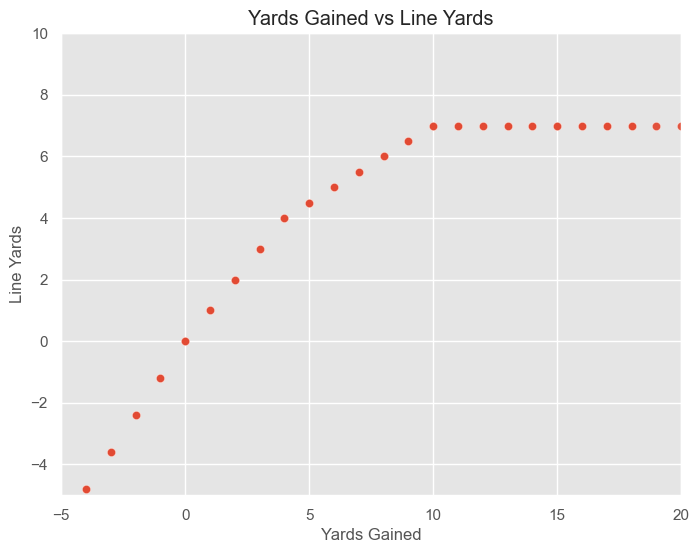

In [281]:
# plot yards gained vs line_yards
plt.style.use('ggplot')
plt.figure(figsize=(8, 6))
sns.scatterplot(x='yards_gained', y='line_yards', data=df_flat, alpha=0.3)
plt.xlim(-5, 20)
plt.ylim(-5, 10)
plt.xlabel('Yards Gained')
plt.ylabel('Line Yards')
plt.title('Yards Gained vs Line Yards')
plt.show()

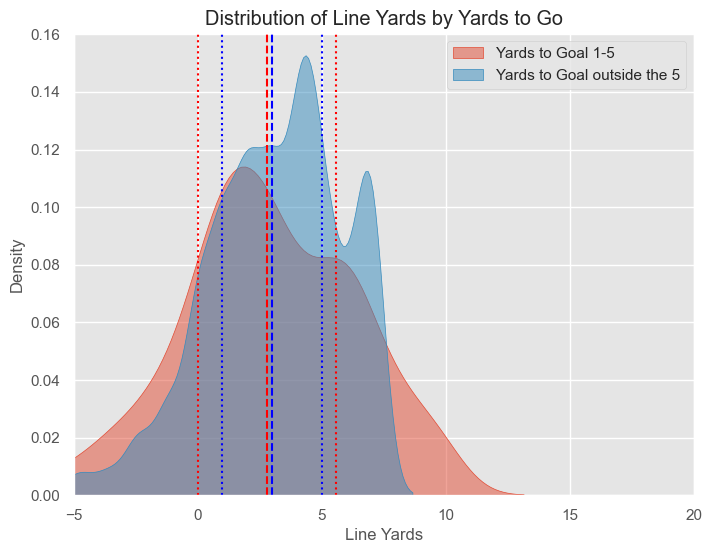

In [282]:
adj_line_yards = 'line_yards_14'

plt.style.use('ggplot')
plt.figure(figsize=(8, 6))
sns.kdeplot(data=df_flat[df_flat.absolute_yardline_number >= 95], x=adj_line_yards, label='Yards to Goal 1-5', fill=True, alpha=0.5)
sns.kdeplot(data=df_flat[(df_flat.absolute_yardline_number < 95)], x='line_yards', label='Yards to Goal outside the 5', fill=True, alpha=0.5)
# plot the 50th percentile line for each
plt.axvline(df_flat[df_flat.absolute_yardline_number >= 95][adj_line_yards].median(), color='red', linestyle='--')
plt.axvline(df_flat[(df_flat.absolute_yardline_number < 95)]['line_yards'].median(), color='blue', linestyle='--')
# plot the 25th and 75th percentile lines for each
plt.axvline(df_flat[df_flat.absolute_yardline_number >= 95][adj_line_yards].quantile(0.25), color='red', linestyle=':')
plt.axvline(df_flat[df_flat.absolute_yardline_number >= 95][adj_line_yards].quantile(0.75), color='red', linestyle=':')
plt.axvline(df_flat[(df_flat.absolute_yardline_number < 95)]['line_yards'].quantile(0.25),    color='blue', linestyle=':') 
plt.axvline(df_flat[(df_flat.absolute_yardline_number < 95)]['line_yards'].quantile(0.75),    color='blue', linestyle=':')
plt.xlim(-5, 20)
plt.xlabel('Line Yards')
plt.ylabel('Density')
plt.title('Distribution of Line Yards by Yards to Go')
plt.legend()
plt.show()

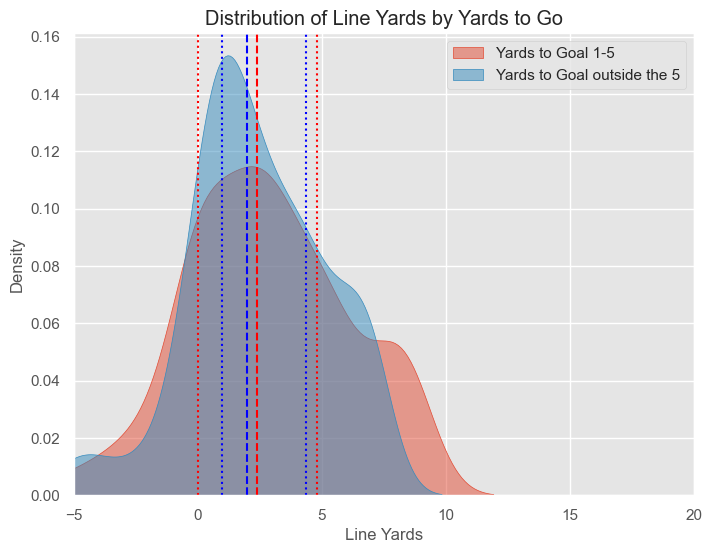

In [283]:
adj_line_yards = 'line_yards_12'

cond = 'down.isin([3,4]) and yards_to_go <= 2'

plt.style.use('ggplot')
plt.figure(figsize=(8, 6))
sns.kdeplot(data=df_flat.query(cond), x=adj_line_yards, label='Yards to Goal 1-5', fill=True, alpha=0.5)
sns.kdeplot(data=df_flat.query(f'~{cond}'), x='line_yards', label='Yards to Goal outside the 5', fill=True, alpha=0.5)
# plot the 50th percentile line for each
plt.axvline(df_flat.query(cond)[adj_line_yards].median(), color='red', linestyle='--')
plt.axvline(df_flat.query(f'~{cond}')['line_yards'].median(), color='blue', linestyle='--')
# plot the 25th and 75th percentile lines for each
plt.axvline(df_flat.query(cond)[adj_line_yards].quantile(0.25), color='red', linestyle=':')
plt.axvline(df_flat.query(cond)[adj_line_yards].quantile(0.75), color='red', linestyle=':')
plt.axvline(df_flat.query(f'~{cond}')['line_yards'].quantile(0.25),    color='blue', linestyle=':') 
plt.axvline(df_flat.query(f'~{cond}')['line_yards'].quantile(0.75),    color='blue', linestyle=':')
plt.xlim(-5, 20)
plt.xlabel('Line Yards')
plt.ylabel('Density')
plt.title('Distribution of Line Yards by Yards to Go')
plt.legend()
plt.show()

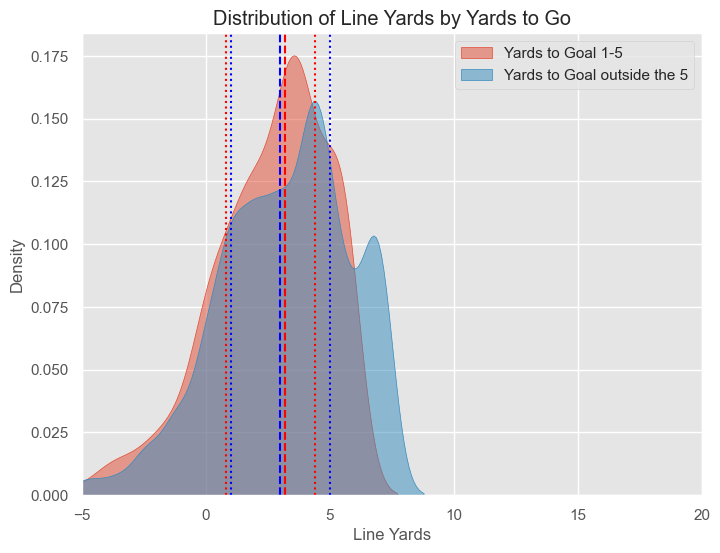

In [284]:
adj_line_yards = 'line_yards_08'

cond = 'down.isin([2,3,4]) and yards_to_go >= 8'

plt.style.use('ggplot')
plt.figure(figsize=(8, 6))
sns.kdeplot(data=df_flat.query(cond), x=adj_line_yards, label='Yards to Goal 1-5', fill=True, alpha=0.5)
sns.kdeplot(data=df_flat.query(f'~{cond}'), x='line_yards', label='Yards to Goal outside the 5', fill=True, alpha=0.5)
# plot the 50th percentile line for each
plt.axvline(df_flat.query(cond)[adj_line_yards].median(), color='red', linestyle='--')
plt.axvline(df_flat.query(f'~{cond}')['line_yards'].median(), color='blue', linestyle='--')
# plot the 25th and 75th percentile lines for each
plt.axvline(df_flat.query(cond)[adj_line_yards].quantile(0.25), color='red', linestyle=':')
plt.axvline(df_flat.query(cond)[adj_line_yards].quantile(0.75), color='red', linestyle=':')
plt.axvline(df_flat.query(f'~{cond}')['line_yards'].quantile(0.25),    color='blue', linestyle=':') 
plt.axvline(df_flat.query(f'~{cond}')['line_yards'].quantile(0.75),    color='blue', linestyle=':')
plt.xlim(-5, 20)
plt.xlabel('Line Yards')
plt.ylabel('Density')
plt.title('Distribution of Line Yards by Yards to Go')
plt.legend()
plt.show()

In [287]:
df_flat[['oline_fc_sum','line_yards']].corr(method='spearman') **2

,oline_fc_sum,line_yards
oline_fc_sum,1.000000,0.002355
line_yards,0.002355,1.000000


In [203]:
plays.head()

,game_play_id,game_id,play_id,play_description,quarter,down,yards_to_go,possession_team,defensive_team,game_clock,pre_snap_home_score,pre_snap_visitor_score,absolute_yardline_number,pre_snap_home_team_win_probability,pre_snap_visitor_team_win_probability,expected_points,offense_formation,receiver_alignment,play_clock_at_snap,rush_location_type,yards_gained,home_team_win_probability_added,visitor_team_win_probility_added,expected_points_added,pff_run_concept_primary,pff_pass_coverage,pff_man_zone
0,2022100205_2314,2022100205,2314,(14:15) Ja.Williams up the middle to DET 32 fo...,3,2,6,DET,SEA,14:15,15,31,39,0.138289,0.861711,1.066931,SINGLEBACK,3x1,15.0,INSIDE_RIGHT,3,-0.024210,0.024210,-0.442517,MAN,Cover 6-Left,Zone
1,2022102306_3240,2022102306,3240,(12:55) (Shotgun) A.Dillon left tackle to WAS ...,4,2,10,GB,WAS,12:55,20,14,64,0.630746,0.369254,2.416086,SHOTGUN,3x1,4.0,INSIDE_LEFT,0,0.053308,-0.053308,-0.962012,PULL LEAD,Cover-6 Right,Zone
2,2022101601_2344,2022101601,2344,(10:13) (No Huddle) K.Hunt right tackle to CLV...,3,1,10,CLE,NE,10:13,6,17,46,0.229286,0.770714,2.069337,SINGLEBACK,2x2,18.0,OUTSIDE_RIGHT,1,0.000048,-0.000048,-0.467615,OUTSIDE ZONE,Cover-3,Zone
3,2022092509_2694,2022092509,2694,(8:21) T.Etienne up the middle to LAC 45 for -...,3,1,5,JAX,LAC,08:21,10,23,66,0.108009,0.891991,3.489420,SINGLEBACK,3x1,19.0,INSIDE_LEFT,-1,-0.001843,0.001843,-0.587710,MAN,Cover 6-Left,Zone
4,2022102700_710,2022102700,710,(3:19) L.Fournette right end to BLT 30 for 1 y...,1,2,1,TB,BAL,03:19,7,3,79,0.745433,0.254567,4.345410,SINGLEBACK,2x2,9.0,INSIDE_RIGHT,1,-0.000940,0.000940,-0.176920,PULL LEAD,Cover-1,Man


In [204]:
df_flat.head()

,game_play_id,lt_fc_attribution,lg_fc_attribution,c_fc_attribution,rg_fc_attribution,rt_fc_attribution,baseline_fc,possession_team,yards_to_go,absolute_yardline_number,down,yards_gained,line_yards,line_yards_20,line_yards_18,line_yards_16,line_yards_15,line_yards_14,line_yards_12,line_yards_08,line_yards_06,adjusted_line_yards,oline_sum
0,2022090800_101,0.021471,0.009602,0.015155,0.021618,0.035633,0.447097,BUF,10,48,1,7,5.5,11.0,9.9,8.8,8.25,7.7,6.6,4.4,3.3,5.5,0.103480
1,2022090800_1187,0.110851,0.104601,0.082128,0.090620,0.069560,0.521216,LA,10,50,1,4,4.0,8.0,7.2,6.4,6.00,5.6,4.8,3.2,2.4,4.0,0.457760
2,2022090800_1385,0.024059,0.011771,0.039129,0.019150,0.002786,0.452042,LA,10,85,1,18,7.0,14.0,12.6,11.2,10.50,9.8,8.4,5.6,4.2,7.0,0.096896
3,2022090800_1406,0.005963,0.105605,0.046921,0.105372,0.098307,0.482094,LA,7,103,1,3,3.0,6.0,5.4,4.8,4.50,4.2,3.6,2.4,1.8,4.2,0.362168
4,2022090800_1736,0.076925,0.132584,0.071048,0.095670,0.043092,0.583060,LA,1,79,2,0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.419319


In [268]:
# group by possession_team, take the median and mean of oline_sum, and sum line_yards
team_summary = (
    df_flat
    .groupby('possession_team')
    .agg(
        mean_oline_sum = ('oline_fc_sum', 'mean'),
        # median_oline_sum = ('oline_sum', 'median'),
        # mean_oline_sum = ('oline_sum', 'mean'),
        total_line_yards = ('adjusted_line_yards', 'sum'),
        average_line_yards = ('adjusted_line_yards', 'mean'),
        median_line_yards = ('adjusted_line_yards', 'median'),
        median_yards_gained = ('yards_gained', 'median'),
        mean_yards_gained = ('yards_gained', 'mean'),
        n_plays = ('game_play_id', 'count')
    )
    .reset_index()
    .sort_values('mean_oline_sum', ascending=False)
)

In [272]:
# correlateion r-squared between median_oline_sum and total_line_yards
team_summary[['mean_oline_sum', 'average_line_yards']].corr(method='spearman')

,mean_oline_sum,average_line_yards
mean_oline_sum,1.000000,-0.042889
average_line_yards,-0.042889,1.000000


In [241]:
for tm in team_summary.itertuples():
    print(f'"{tm.possession_team}": ,')

"PHI": ,
"IND": ,
"KC": ,
"CIN": ,
"CLE": ,
"WAS": ,
"NE": ,
"HOU": ,
"SEA": ,
"ARI": ,
"TB": ,
"DAL": ,
"NYG": ,
"NYJ": ,
"PIT": ,
"CAR": ,
"NO": ,
"DET": ,
"GB": ,
"TEN": ,
"MIA": ,
"LA": ,
"LAC": ,
"BAL": ,
"BUF": ,
"LV": ,
"ATL": ,
"CHI": ,
"DEN": ,
"SF": ,
"JAX": ,
"MIN": ,


In [ ]:
pff_grades = {
    "PHI": 73.7,
    "IND": 62,
    "KC": 74.1,
    "CIN": 54.6,
    "CLE": 69.2,
    "WAS": 55.6,
    "NE": 56.7,
    "HOU": 47.9,
    "SEA": 57.8,
    "ARI": 47.0,
    "TB": 54.0,
    "DAL": 63.8,
    "NYG": 61.0,
    "NYJ": 52.0,
    "PIT": 58.0,
    "CAR": 56.0,
    "NO": 53.0,
    "DET": 68.8,
    "GB": 55.9,
    "TEN": 62.3,
    "MIA": 69.9,
    "LA": 57.3,
    "LAC": 45.7,
    "BAL": 77.2,
    "BUF": 51.6,
    "LV": 57.9,
    "ATL": 83.7,
    "CHI": 73.1,
    "DEN": 59.4,
    "SF": 67.5,
    "JAX": 47.0,
    "MIN": 74.5,
}

team_summary['pff_grade'] = team_summary['possession_team'].map(pff_grades)

In [290]:
attrib_df.head()

,game_play_id,player_id,position,fc_attribution,baseline_fc
0,2022090800_101,35472.0,LG,0.009602,0.447097
1,2022090800_101,42392.0,C,0.015155,0.447097
2,2022090800_101,44875.0,LT,0.021471,0.447097
3,2022090800_101,48512.0,RG,0.021618,0.447097
4,2022090800_101,53522.0,RT,0.035633,0.447097


In [248]:
# sum the values of the top 3 oline players for each team
top_3_oline = (
    df_flat
    .groupby('possession_team')
    .apply(lambda x: x.nlargest(5, 'oline_sum')['oline_sum'].sum())
    .reset_index(name='top_3_oline_sum')
)
team_summary = team_summary.merge(top_3_oline, on='possession_team', how='left')

In [249]:
team_summary.sort_values('top_3_oline_sum', ascending=False)

KeyError: 'top_3_oline_sum'

In [266]:
# plot oline_fc_sum vs median_line_yards
plt.style.use('ggplot')
plt.figure(figsize=(10, 6))
sns.scatterplot(x='oline_fc_sum', y='pff_grade', data=team_summary, s=100, alpha=0.5)
# best fit line
sns.regplot(x='oline_fc_sum', y='pff_grade', data=team_summary, scatter=False, color='red')
plt.xlabel('Median O-Line FCA Sum')
plt.ylabel('Total Adjusted Line Yards')
plt.title('Team O-Line FCA vs Total Adjusted Line Yards')
plt.show()


ValueError: Could not interpret value `oline_fc_sum` for `x`. An entry with this name does not appear in `data`.

<Figure size 1000x600 with 0 Axes>

In [273]:
df_flat.head()

,game_play_id,lt_fc_attribution,lg_fc_attribution,c_fc_attribution,rg_fc_attribution,rt_fc_attribution,baseline_fc,possession_team,yards_to_go,absolute_yardline_number,rush_location_type,down,yards_gained,line_yards,line_yards_20,line_yards_18,line_yards_16,line_yards_15,line_yards_14,line_yards_12,line_yards_08,line_yards_06,adjusted_line_yards,oline_fc_sum
0,2022090800_101,0.021471,0.009602,0.015155,0.021618,0.035633,0.447097,BUF,10,48,INSIDE_RIGHT,1,7,5.5,11.0,9.9,8.8,8.25,7.7,6.6,4.4,3.3,5.5,0.072407
1,2022090800_1187,0.110851,0.104601,0.082128,0.090620,0.069560,0.521216,LA,10,50,INSIDE_LEFT,1,4,4.0,8.0,7.2,6.4,6.00,5.6,4.8,3.2,2.4,4.0,0.297580
2,2022090800_1385,0.024059,0.011771,0.039129,0.019150,0.002786,0.452042,LA,10,85,INSIDE_LEFT,1,18,7.0,14.0,12.6,11.2,10.50,9.8,8.4,5.6,4.2,7.0,0.074959
3,2022090800_1406,0.005963,0.105605,0.046921,0.105372,0.098307,0.482094,LA,7,103,INSIDE_RIGHT,1,3,3.0,6.0,5.4,4.8,4.50,4.2,3.6,2.4,1.8,4.2,0.250600
4,2022090800_1736,0.076925,0.132584,0.071048,0.095670,0.043092,0.583060,LA,1,79,INSIDE_RIGHT,2,0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.209809


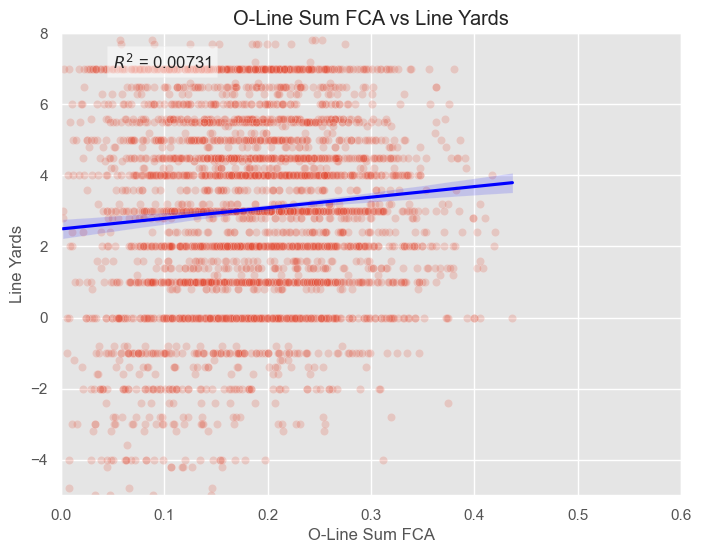

In [279]:
# plot oline_fc_sum vs line_yards
plt.style.use('ggplot')
plt.figure(figsize=(8, 6))
sns.scatterplot(x='oline_fc_sum', y='adjusted_line_yards', data=df_flat, alpha=0.2)
# plot r-squared
r_squared = df_flat[['oline_fc_sum','adjusted_line_yards']].corr().iloc[0,1]**2
plt.text(0.05, 7, f"$R^2$ = {r_squared:.5f}", fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
# best fit line
sns.regplot(x='oline_fc_sum', y='adjusted_line_yards', data=df_flat, scatter=False, color='blue')
plt.xlim(0, .6)
plt.ylim(-5, 8)
plt.xlabel('O-Line Sum FCA')
plt.ylabel('Line Yards')
plt.title('O-Line Sum FCA vs Line Yards')
plt.show()

In [276]:
0.054535 ** 2

0.002974066225

In [289]:
team_summary.sort_values('mean_oline_sum', ascending=False)

,possession_team,mean_oline_sum,total_line_yards,average_line_yards,median_line_yards,median_yards_gained,mean_yards_gained,n_plays
13,IND,0.213479,304.1,2.555462,2.4,2.0,3.621849,119
6,CIN,0.204902,229.5,2.700000,3.0,3.0,3.047059,85
31,WAS,0.204431,307.0,2.816514,3.0,3.0,4.073394,109
25,PHI,0.204080,322.3,3.357292,3.0,3.0,4.322917,96
7,CLE,0.204030,521.5,3.321656,3.0,3.0,5.229299,157
15,KC,0.203763,168.0,2.754098,3.0,3.0,3.672131,61
23,NYG,0.199353,297.3,2.973000,3.0,3.0,4.990000,100
4,CAR,0.195718,276.8,3.075556,3.2,3.0,4.766667,90
26,PIT,0.195617,222.2,2.677108,3.0,3.0,3.397590,83
21,NE,0.194790,410.1,3.203906,3.6,4.0,5.031250,128


In [293]:
games.head()

,game_id,season,week,game_date,game_time_eastern,home_team_abbr,visitor_team_abbr,home_final_score,visitor_final_score
0,2022090800,2022,1,9/8/2022,20:20:00,LA,BUF,10,31
1,2022091100,2022,1,9/11/2022,13:00:00,ATL,NO,26,27
2,2022091101,2022,1,9/11/2022,13:00:00,CAR,CLE,24,26
3,2022091102,2022,1,9/11/2022,13:00:00,CHI,SF,19,10
4,2022091103,2022,1,9/11/2022,13:00:00,CIN,PIT,20,23


# Evaluation of Metric Stability

In [310]:
metric_stability = (
    games[['game_id','week']]
    .merge(
        attrib_df.assign(game_id=lambda x: x['game_play_id'].str.split('_').str[0].astype(int)),
        on='game_id',
        how='left'
    )
)

metric_stability.head()


# get the R squared of the mean player fc_attribution weeks 1-4 vs weeks 5-9 for each position
stability_results = []
for position in attrib_df['position'].unique():
    pos_data = metric_stability[metric_stability['position'] == position]
    week1_4 = (
        pos_data[pos_data['week'].isin([1, 2, 3, 4, 5])]
        .groupby('player_id')['fc_attribution']
        .mean()
        .reset_index(name='week1_4_fc')
    )
    week5_9 = (
        pos_data[pos_data['week'].isin([6, 7, 8, 9])]
        .groupby('player_id')['fc_attribution']
        .mean()
        .reset_index(name='week5_9_fc')
    )
    merged = week1_4.merge(week5_9, on='player_id', how='inner')
    if len(merged) > 1:
        r_squared = merged[['week1_4_fc', 'week5_9_fc']].corr().iloc[0, 1] ** 2
        stability_results.append({'position': position, 'r_squared': r_squared})
stability_df = pd.DataFrame(stability_results).sort_values('r_squared', ascending=False)

In [311]:
stability_df

,position,r_squared
3,RG,0.247670
1,C,0.213780
0,LG,0.148951
4,RT,0.066648
2,LT,0.027584


/Users/lukeneuendorf/miniforge3/envs/nfl-oline/lib/python3.11/site-packages/plottable/table.py:543: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  cell.text.set_bbox(


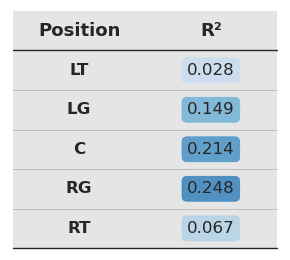

In [317]:
import matplotlib.pyplot as plt
from plottable import Table, ColumnDefinition
from plottable.cmap import normed_cmap
import matplotlib

# order as LT, LG, C, RG, RT
stability_df = stability_df.set_index('position').reindex(['LT', 'LG', 'C', 'RG', 'RT']).reset_index()

# Define column definitions
col_defs = [
    ColumnDefinition(
        name="position",
        title="Position",
        textprops={"ha": "center", "weight": "bold"},
        width=1.0,
    ),
    ColumnDefinition(
        name="r_squared",
        title="R²",
        textprops={
            "ha": "center",
            "bbox": {"boxstyle": "round,pad=0.3", "facecolor": "white", "edgecolor": "none", "alpha": 0.8},
        },
        formatter=lambda x: f"{x:.3f}",
        cmap=normed_cmap(stability_df["r_squared"], cmap=matplotlib.cm.Blues, num_stds=2.5),
        width=1.0,
    )
]

# Figure setup
plt.rcParams["font.family"] = ["DejaVu Sans"]
fig, ax = plt.subplots(figsize=(3, 3))

# Create the table
table = Table(
    stability_df,
    column_definitions=col_defs,
    row_dividers=True,
    footer_divider=True,
    ax=ax,
    textprops={"fontsize": 12},
    row_divider_kw={"linewidth": 0.5, "linestyle": "-", "alpha": 0.3},
    col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
    column_border_kw={"linewidth": 1, "linestyle": "-"},
    index_col="position"  # This hides the default index
)

# Style column headers
for cell in table.col_label_row.cells:
    if hasattr(cell, "text") and cell.text is not None:
        cell.text.set_fontweight("bold")
        cell.text.set_fontsize(13)

# Title
# fig.suptitle(
#     "Run Blocking Stability by Position",
#     fontsize=16,
#     fontweight="bold",
#     y=0.95,
#     ha="center", va="center",
# )

# # Subtitle
# fig.text(
#     0.5, 0.90,
#     "R² values for run blocking performance stability (2022 Weeks 1-9)",
#     fontsize=10,
#     ha="center", va="center",
#     style='italic'
# )

# Adjust layout to prevent cutting off
plt.tight_layout(rect=[0, 0, 1, 0.9])

plt.show()

In [320]:
import nfl_data_py as nfl
cols = nfl.see_pbp_cols()

for c in cols:
    print(c)


play_id
game_id
old_game_id
home_team
away_team
season_type
week
posteam
posteam_type
defteam
side_of_field
yardline_100
game_date
quarter_seconds_remaining
half_seconds_remaining
game_seconds_remaining
game_half
quarter_end
drive
sp
qtr
down
goal_to_go
time
yrdln
ydstogo
ydsnet
desc
play_type
yards_gained
shotgun
no_huddle
qb_dropback
qb_kneel
qb_spike
qb_scramble
pass_length
pass_location
air_yards
yards_after_catch
run_location
run_gap
field_goal_result
kick_distance
extra_point_result
two_point_conv_result
home_timeouts_remaining
away_timeouts_remaining
timeout
timeout_team
td_team
td_player_name
td_player_id
posteam_timeouts_remaining
defteam_timeouts_remaining
total_home_score
total_away_score
posteam_score
defteam_score
score_differential
posteam_score_post
defteam_score_post
score_differential_post
no_score_prob
opp_fg_prob
opp_safety_prob
opp_td_prob
fg_prob
safety_prob
td_prob
extra_point_prob
two_point_conversion_prob
ep
epa
total_home_epa
total_away_epa
total_home_rush_epa


In [330]:
pfr_data = nfl.import_weekly_pfr('rush',[2022])
pfr_data.head()

,game_id,pfr_game_id,season,week,game_type,team,opponent,pfr_player_name,pfr_player_id,carries,rushing_yards_before_contact,rushing_yards_before_contact_avg,rushing_yards_after_contact,rushing_yards_after_contact_avg,rushing_broken_tackles,receiving_broken_tackles
0,2022_01_BUF_LA,202209080ram,2022,1,REG,LA,BUF,Darrell Henderson,HendDa00,13.0,30.0,2.3,17.0,1.3,0.0,NaN
1,2022_01_BUF_LA,202209080ram,2022,1,REG,LA,BUF,Cam Akers,AkerCa00,3.0,0.0,0.0,0.0,0.0,0.0,NaN
2,2022_01_BUF_LA,202209080ram,2022,1,REG,LA,BUF,Brandon Powell,PoweBr00,1.0,3.0,3.0,0.0,0.0,0.0,NaN
3,2022_01_BUF_LA,202209080ram,2022,1,REG,LA,BUF,Matthew Stafford,StafMa00,1.0,2.0,2.0,0.0,0.0,0.0,NaN
4,2022_01_BUF_LA,202209080ram,2022,1,REG,BUF,LA,Josh Allen,AlleJo02,10.0,36.0,3.6,20.0,2.0,0.0,NaN


In [333]:
players.head()

,nfl_id,height,weight,birth_date,college_name,position,display_name
0,25511,6-4,225,1977-08-03,Michigan,QB,Tom Brady
1,29550,6-4,328,1982-01-22,Arkansas,T,Jason Peters
2,29851,6-2,225,1983-12-02,California,QB,Aaron Rodgers
3,30842,6-6,267,1984-05-19,UCLA,TE,Marcedes Lewis
4,33084,6-4,217,1985-05-17,Boston College,QB,Matt Ryan


In [342]:
players.query('display_name == "Matthew Stafford"')

,nfl_id,height,weight,birth_date,college_name,position,display_name
11,34452,6-3,220,1988-02-07,Georgia,QB,Matthew Stafford


In [343]:
nfl.import_ids().query('name == "Matthew Stafford"')

,stats_id,gsis_id,fantasy_data_id,ktc_id,fleaflicker_id,birthdate,swish_id,twitter_username,cfbref_id,nfl_id,sleeper_id,cbs_id,draft_round,draft_ovr,rotoworld_id,merge_name,age,mfl_id,weight,yahoo_id,height,espn_id,pff_id,rotowire_id,position,name,draft_pick,stats_global_id,pfr_id,fantasypros_id,db_season,sportradar_id,team,college,draft_year
6330,9265.0,00-0026498,9038.0,356.0,6038.0,1988-02-07,323205.0,Staff_9,matthew-stafford-1,matthewstafford/79860,421.0,1114942.0,1.0,1.0,5132.0,matthew stafford,37.5,9431,214.0,9265.0,75.0,12483.0,4924.0,5971.0,QB,Matthew Stafford,1.0,323205.0,StafMa00,9451.0,2025,ade43b1a-0601-4672-83b6-d246bc066a19,LAR,Georgia,2009.0


In [335]:
pfr_data.head()

,game_id,pfr_game_id,season,week,game_type,team,opponent,pfr_player_name,pfr_player_id,carries,rushing_yards_before_contact,rushing_yards_before_contact_avg,rushing_yards_after_contact,rushing_yards_after_contact_avg,rushing_broken_tackles,receiving_broken_tackles
0,2022_01_BUF_LA,202209080ram,2022,1,REG,LA,BUF,Darrell Henderson,HendDa00,13.0,30.0,2.3,17.0,1.3,0.0,NaN
1,2022_01_BUF_LA,202209080ram,2022,1,REG,LA,BUF,Cam Akers,AkerCa00,3.0,0.0,0.0,0.0,0.0,0.0,NaN
2,2022_01_BUF_LA,202209080ram,2022,1,REG,LA,BUF,Brandon Powell,PoweBr00,1.0,3.0,3.0,0.0,0.0,0.0,NaN
3,2022_01_BUF_LA,202209080ram,2022,1,REG,LA,BUF,Matthew Stafford,StafMa00,1.0,2.0,2.0,0.0,0.0,0.0,NaN
4,2022_01_BUF_LA,202209080ram,2022,1,REG,BUF,LA,Josh Allen,AlleJo02,10.0,36.0,3.6,20.0,2.0,0.0,NaN


In [379]:
df_flat.head()

,game_play_id,lt_fc_attribution,lg_fc_attribution,c_fc_attribution,rg_fc_attribution,rt_fc_attribution,baseline_fc,possession_team,yards_to_go,absolute_yardline_number,rush_location_type,down,yards_gained,line_yards,line_yards_20,line_yards_18,line_yards_16,line_yards_15,line_yards_14,line_yards_12,line_yards_08,line_yards_06,adjusted_line_yards,oline_fc_sum
0,2022090800_101,0.021471,0.009602,0.015155,0.021618,0.035633,0.447097,BUF,10,48,INSIDE_RIGHT,1,7,5.5,11.0,9.9,8.8,8.25,7.7,6.6,4.4,3.3,5.5,0.072407
1,2022090800_1187,0.110851,0.104601,0.082128,0.090620,0.069560,0.521216,LA,10,50,INSIDE_LEFT,1,4,4.0,8.0,7.2,6.4,6.00,5.6,4.8,3.2,2.4,4.0,0.297580
2,2022090800_1385,0.024059,0.011771,0.039129,0.019150,0.002786,0.452042,LA,10,85,INSIDE_LEFT,1,18,7.0,14.0,12.6,11.2,10.50,9.8,8.4,5.6,4.2,7.0,0.074959
3,2022090800_1406,0.005963,0.105605,0.046921,0.105372,0.098307,0.482094,LA,7,103,INSIDE_RIGHT,1,3,3.0,6.0,5.4,4.8,4.50,4.2,3.6,2.4,1.8,4.2,0.250600
4,2022090800_1736,0.076925,0.132584,0.071048,0.095670,0.043092,0.583060,LA,1,79,INSIDE_RIGHT,2,0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.209809


In [381]:
games.head()

,game_id,season,week,game_date,game_time_eastern,home_team_abbr,visitor_team_abbr,home_final_score,visitor_final_score
0,2022090800,2022,1,9/8/2022,20:20:00,LA,BUF,10,31
1,2022091100,2022,1,9/11/2022,13:00:00,ATL,NO,26,27
2,2022091101,2022,1,9/11/2022,13:00:00,CAR,CLE,24,26
3,2022091102,2022,1,9/11/2022,13:00:00,CHI,SF,19,10
4,2022091103,2022,1,9/11/2022,13:00:00,CIN,PIT,20,23


In [380]:
pfr_data.head()

,game_id,pfr_game_id,season,week,game_type,team,opponent,pfr_player_name,pfr_player_id,carries,rushing_yards_before_contact,rushing_yards_before_contact_avg,rushing_yards_after_contact,rushing_yards_after_contact_avg,rushing_broken_tackles,receiving_broken_tackles
0,2022_01_BUF_LA,202209080ram,2022,1,REG,LA,BUF,Darrell Henderson,HendDa00,13.0,30.0,2.3,17.0,1.3,0.0,NaN
1,2022_01_BUF_LA,202209080ram,2022,1,REG,LA,BUF,Cam Akers,AkerCa00,3.0,0.0,0.0,0.0,0.0,0.0,NaN
2,2022_01_BUF_LA,202209080ram,2022,1,REG,LA,BUF,Brandon Powell,PoweBr00,1.0,3.0,3.0,0.0,0.0,0.0,NaN
3,2022_01_BUF_LA,202209080ram,2022,1,REG,LA,BUF,Matthew Stafford,StafMa00,1.0,2.0,2.0,0.0,0.0,0.0,NaN
4,2022_01_BUF_LA,202209080ram,2022,1,REG,BUF,LA,Josh Allen,AlleJo02,10.0,36.0,3.6,20.0,2.0,0.0,NaN


In [389]:
if 'game_id_pfr' in df_flat.columns:
    df_flat = df_flat.drop(columns=['game_id_pfr'])

df_flat = (
    df_flat.merge(
        games.assign(
            game_id_pfr = lambda x: x['season'].astype(str) + '_' + x['week'].astype(str) + '_' + x['visitor_team_abbr'] + '_' + x['home_team_abbr']
        )[['game_id', 'game_id_pfr']],
        left_on=df_flat['game_play_id'].str.split('_').str[0].astype(int),
        right_on='game_id',
        how='left'
    )
    .drop(columns=['game_id'])
)

df_flat.head()

,game_play_id,lt_fc_attribution,lg_fc_attribution,c_fc_attribution,rg_fc_attribution,rt_fc_attribution,baseline_fc,possession_team,yards_to_go,absolute_yardline_number,rush_location_type,down,yards_gained,line_yards,line_yards_20,line_yards_18,line_yards_16,line_yards_15,line_yards_14,line_yards_12,line_yards_08,line_yards_06,adjusted_line_yards,oline_fc_sum,game_id_pfr
0,2022090800_101,0.021471,0.009602,0.015155,0.021618,0.035633,0.447097,BUF,10,48,INSIDE_RIGHT,1,7,5.5,11.0,9.9,8.8,8.25,7.7,6.6,4.4,3.3,5.5,0.072407,2022_1_BUF_LA
1,2022090800_1187,0.110851,0.104601,0.082128,0.090620,0.069560,0.521216,LA,10,50,INSIDE_LEFT,1,4,4.0,8.0,7.2,6.4,6.00,5.6,4.8,3.2,2.4,4.0,0.297580,2022_1_BUF_LA
2,2022090800_1385,0.024059,0.011771,0.039129,0.019150,0.002786,0.452042,LA,10,85,INSIDE_LEFT,1,18,7.0,14.0,12.6,11.2,10.50,9.8,8.4,5.6,4.2,7.0,0.074959,2022_1_BUF_LA
3,2022090800_1406,0.005963,0.105605,0.046921,0.105372,0.098307,0.482094,LA,7,103,INSIDE_RIGHT,1,3,3.0,6.0,5.4,4.8,4.50,4.2,3.6,2.4,1.8,4.2,0.250600,2022_1_BUF_LA
4,2022090800_1736,0.076925,0.132584,0.071048,0.095670,0.043092,0.583060,LA,1,79,INSIDE_RIGHT,2,0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.209809,2022_1_BUF_LA


In [ ]:
 (pfr_data.query('week.between(1,9)')[['game_id','pfr_player_id','team','carries','rushing_yards_before_contact']]
    .merge(
        nfl.import_ids()[['pfr_id','position']].rename(columns={'pfr_id':'pfr_player_id'}),
        on='pfr_player_id',
        how='left'
    )
    .query('position == "RB"')
    .drop(columns=['position','pfr_player_id'])).head()

,game_id,week,team,carries,rushing_yards_before_contact
0,2022_01_BUF_LA,1,LA,13.0,30.0
1,2022_01_BUF_LA,1,LA,3.0,0.0
5,2022_01_BUF_LA,1,BUF,8.0,33.0
6,2022_01_BUF_LA,1,BUF,6.0,12.0
7,2022_01_BUF_LA,1,BUF,1.0,2.0


In [392]:
pfr_data.head()

,game_id,pfr_game_id,season,week,game_type,team,opponent,pfr_player_name,pfr_player_id,carries,rushing_yards_before_contact,rushing_yards_before_contact_avg,rushing_yards_after_contact,rushing_yards_after_contact_avg,rushing_broken_tackles,receiving_broken_tackles
0,2022_01_BUF_LA,202209080ram,2022,1,REG,LA,BUF,Darrell Henderson,HendDa00,13.0,30.0,2.3,17.0,1.3,0.0,NaN
1,2022_01_BUF_LA,202209080ram,2022,1,REG,LA,BUF,Cam Akers,AkerCa00,3.0,0.0,0.0,0.0,0.0,0.0,NaN
2,2022_01_BUF_LA,202209080ram,2022,1,REG,LA,BUF,Brandon Powell,PoweBr00,1.0,3.0,3.0,0.0,0.0,0.0,NaN
3,2022_01_BUF_LA,202209080ram,2022,1,REG,LA,BUF,Matthew Stafford,StafMa00,1.0,2.0,2.0,0.0,0.0,0.0,NaN
4,2022_01_BUF_LA,202209080ram,2022,1,REG,BUF,LA,Josh Allen,AlleJo02,10.0,36.0,3.6,20.0,2.0,0.0,NaN


In [394]:
nfl.import_ftn_data([2022]).head()

Downcasting floats.


,ftn_game_id,nflverse_game_id,season,week,ftn_play_id,nflverse_play_id,starting_hash,qb_location,n_offense_backfield,n_defense_box,is_no_huddle,is_motion,is_play_action,is_screen_pass,is_rpo,is_trick_play,is_qb_out_of_pocket,is_interception_worthy,is_throw_away,read_thrown,is_catchable_ball,is_contested_ball,is_created_reception,is_drop,is_qb_sneak,n_blitzers,n_pass_rushers,is_qb_fault_sack,date_pulled
0,5879,2022_01_BUF_LA,2022,1,963918,56,R,S,1,6,False,False,False,False,False,False,False,False,False,1,True,False,False,False,False,0,4,False,2024-09-06 23:50:14.696374
1,5879,2022_01_BUF_LA,2022,1,963919,80,R,S,1,6,True,True,False,False,False,False,False,False,False,None,False,False,False,False,False,0,4,False,2024-09-06 23:50:14.696374
2,5879,2022_01_BUF_LA,2022,1,963920,101,R,U,1,7,False,True,False,False,False,False,False,False,False,None,False,False,False,False,False,0,0,False,2024-09-06 23:50:14.696374
3,5879,2022_01_BUF_LA,2022,1,963921,122,R,S,2,6,False,False,False,False,False,False,False,False,False,CHK,True,False,False,False,False,1,5,False,2024-09-06 23:50:14.696374
4,5879,2022_01_BUF_LA,2022,1,963922,146,R,S,1,6,False,True,False,False,False,False,False,False,False,None,False,False,False,False,False,0,0,False,2024-09-06 23:50:14.696374


In [ ]:
rybc = (
    pfr_data.query('week.between(1,9)')[['pfr_player_id','team','carries','rushing_yards_before_contact']]
    .merge(
        nfl.import_ids()[['pfr_id','position']].rename(columns={'pfr_id':'pfr_player_id'}),
        on='pfr_player_id',
        how='left'
    )
    .query('position == "RB"')
    .drop(columns=['position','pfr_player_id'])
    .groupby(['team'])
    .agg(
        N_Carries = ('carries','sum'),
        RYBC = ('rushing_yards_before_contact','sum')
    )
    .assign(
        RYBC_per_carry = lambda x: x.RYBC / x.N_Carries
    )
    .reset_index()
    .drop(['N_Carries','RYBC'], axis=1)
    .sort_values('RYBC_per_carry', ascending=False, ignore_index=True)
)


rybc

,team,RYBC_per_carry
0,NYJ,3.292553
1,JAX,3.211268
2,SF,3.198718
3,ATL,3.079096
4,SEA,3.069149
5,PHI,3.021622
6,BUF,2.983871
7,DET,2.892308
8,CAR,2.786517
9,GB,2.776699


In [358]:
team_summary.head()

,possession_team,mean_oline_sum,total_line_yards,average_line_yards,median_line_yards,median_yards_gained,mean_yards_gained,n_plays
13,IND,0.213479,304.1,2.555462,2.4,2.0,3.621849,119
6,CIN,0.204902,229.5,2.700000,3.0,3.0,3.047059,85
31,WAS,0.204431,307.0,2.816514,3.0,3.0,4.073394,109
25,PHI,0.204080,322.3,3.357292,3.0,3.0,4.322917,96
7,CLE,0.204030,521.5,3.321656,3.0,3.0,5.229299,157


In [362]:
if 'RYBC_per_carry' in team_summary.columns:
    team_summary = team_summary.drop('RYBC_per_carry', axis=1)

team_summary = team_summary.merge(rybc, left_on='possession_team', right_on='team', how='left').drop('team', axis=1)
team_summary

,possession_team,mean_oline_sum,total_line_yards,average_line_yards,median_line_yards,median_yards_gained,mean_yards_gained,n_plays,RYBC_per_carry
0,IND,0.213479,304.1,2.555462,2.4,2.0,3.621849,119,2.347826
1,CIN,0.204902,229.5,2.700000,3.0,3.0,3.047059,85,2.545455
2,WAS,0.204431,307.0,2.816514,3.0,3.0,4.073394,109,2.135870
3,PHI,0.204080,322.3,3.357292,3.0,3.0,4.322917,96,3.021622
4,CLE,0.204030,521.5,3.321656,3.0,3.0,5.229299,157,2.610390
5,KC,0.203763,168.0,2.754098,3.0,3.0,3.672131,61,1.979730
6,NYG,0.199353,297.3,2.973000,3.0,3.0,4.990000,100,2.368421
7,CAR,0.195718,276.8,3.075556,3.2,3.0,4.766667,90,2.786517
8,PIT,0.195617,222.2,2.677108,3.0,3.0,3.397590,83,2.442029
9,NE,0.194790,410.1,3.203906,3.6,4.0,5.031250,128,2.254630


In [369]:
# correlateion r-squared between median_oline_sum and RYBC_per_carry
team_summary[['mean_oline_sum', 'RYBC_per_carry']].corr(method='spearman') ** 2

,mean_oline_sum,RYBC_per_carry
mean_oline_sum,1.000000,0.028557
RYBC_per_carry,0.028557,1.000000


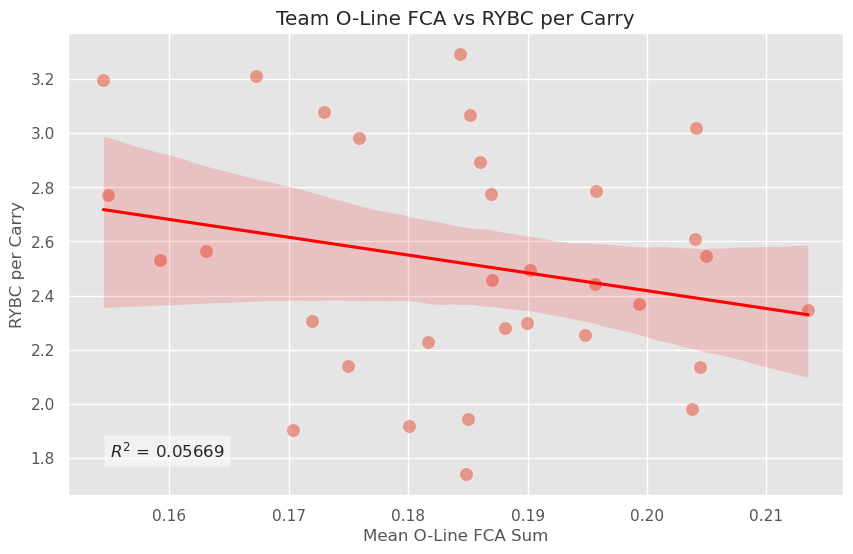

In [377]:
# plot mean_oline_sum vs RYBC_per_carry
plt.style.use('ggplot')
plt.figure(figsize=(10, 6))
sns.scatterplot(x='mean_oline_sum', y='RYBC_per_carry', data=team_summary, s=100, alpha=0.5)
# best fit line 
sns.regplot(x='mean_oline_sum', y='RYBC_per_carry', data=team_summary, scatter=False, color='red')
# plot r-squared
r_squared = team_summary[['mean_oline_sum','RYBC_per_carry']].corr().iloc[0,1]**2
plt.text(.155, 1.8, f"$R^2$ = {r_squared:.5f}", fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
plt.xlabel('Mean O-Line FCA Sum')
plt.ylabel('RYBC per Carry')
plt.title('Team O-Line FCA vs RYBC per Carry')
plt.show()

In [395]:
df_flat.head()

,game_play_id,lt_fc_attribution,lg_fc_attribution,c_fc_attribution,rg_fc_attribution,rt_fc_attribution,baseline_fc,possession_team,yards_to_go,absolute_yardline_number,rush_location_type,down,yards_gained,line_yards,line_yards_20,line_yards_18,line_yards_16,line_yards_15,line_yards_14,line_yards_12,line_yards_08,line_yards_06,adjusted_line_yards,oline_fc_sum,game_id_pfr
0,2022090800_101,0.021471,0.009602,0.015155,0.021618,0.035633,0.447097,BUF,10,48,INSIDE_RIGHT,1,7,5.5,11.0,9.9,8.8,8.25,7.7,6.6,4.4,3.3,5.5,0.072407,2022_1_BUF_LA
1,2022090800_1187,0.110851,0.104601,0.082128,0.090620,0.069560,0.521216,LA,10,50,INSIDE_LEFT,1,4,4.0,8.0,7.2,6.4,6.00,5.6,4.8,3.2,2.4,4.0,0.297580,2022_1_BUF_LA
2,2022090800_1385,0.024059,0.011771,0.039129,0.019150,0.002786,0.452042,LA,10,85,INSIDE_LEFT,1,18,7.0,14.0,12.6,11.2,10.50,9.8,8.4,5.6,4.2,7.0,0.074959,2022_1_BUF_LA
3,2022090800_1406,0.005963,0.105605,0.046921,0.105372,0.098307,0.482094,LA,7,103,INSIDE_RIGHT,1,3,3.0,6.0,5.4,4.8,4.50,4.2,3.6,2.4,1.8,4.2,0.250600,2022_1_BUF_LA
4,2022090800_1736,0.076925,0.132584,0.071048,0.095670,0.043092,0.583060,LA,1,79,INSIDE_RIGHT,2,0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.209809,2022_1_BUF_LA


In [396]:
team_summary.head()

,possession_team,mean_oline_sum,total_line_yards,average_line_yards,median_line_yards,median_yards_gained,mean_yards_gained,n_plays,RYBC_per_carry
0,IND,0.213479,304.1,2.555462,2.4,2.0,3.621849,119,2.347826
1,CIN,0.204902,229.5,2.700000,3.0,3.0,3.047059,85,2.545455
2,WAS,0.204431,307.0,2.816514,3.0,3.0,4.073394,109,2.135870
3,PHI,0.204080,322.3,3.357292,3.0,3.0,4.322917,96,3.021622
4,CLE,0.204030,521.5,3.321656,3.0,3.0,5.229299,157,2.610390


In [398]:
team_summary = (
    team_summary
    .merge(
        df_flat.groupby('possession_team').agg(
            lt_fc_attribution = ('lt_fc_attribution', 'mean'),
            lg_fc_attribution = ('lg_fc_attribution', 'mean'),
            c_fc_attribution  = ('c_fc_attribution', 'mean'),
            rg_fc_attribution = ('rg_fc_attribution', 'mean'),
            rt_fc_attribution = ('rt_fc_attribution', 'mean'),
        ).reset_index(),
        left_on='possession_team',
        right_on='possession_team',
        how='left'
    )
)


In [400]:
team_summary.head()

,possession_team,mean_oline_sum,total_line_yards,average_line_yards,median_line_yards,median_yards_gained,mean_yards_gained,n_plays,RYBC_per_carry,lt_fc_attribution,lg_fc_attribution,c_fc_attribution,rg_fc_attribution,rt_fc_attribution
0,IND,0.213479,304.1,2.555462,2.4,2.0,3.621849,119,2.347826,0.056652,0.066229,0.068368,0.063670,0.056461
1,CIN,0.204902,229.5,2.700000,3.0,3.0,3.047059,85,2.545455,0.050680,0.061924,0.067072,0.065583,0.054627
2,WAS,0.204431,307.0,2.816514,3.0,3.0,4.073394,109,2.135870,0.051752,0.064642,0.062641,0.061686,0.052238
3,PHI,0.204080,322.3,3.357292,3.0,3.0,4.322917,96,3.021622,0.057670,0.067540,0.063431,0.071367,0.052706
4,CLE,0.204030,521.5,3.321656,3.0,3.0,5.229299,157,2.610390,0.051593,0.066228,0.073252,0.060999,0.050170


In [406]:
# predict RYBC_per_carry using lt, lg, c, rg, rt fc_attribution
import statsmodels.formula.api as smf

# create standardized variables for lt, lg, c, rg, rt fc_attribution
for col in ['lt_fc_attribution', 'lg_fc_attribution', 'c_fc_attribution', 'rg_fc_attribution', 'rt_fc_attribution']:
    team_summary[f'std_{col}'] = (team_summary[col] - team_summary[col].mean()) / team_summary[col].std()  
model = smf.ols(
    'RYBC_per_carry ~ std_lt_fc_attribution + std_lg_fc_attribution + std_c_fc_attribution + std_rg_fc_attribution + std_rt_fc_attribution',
    data=team_summary
).fit() 

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         RYBC_per_carry   R-squared:                       0.237
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     1.617
Date:                Sat, 23 Aug 2025   Prob (F-statistic):              0.191
Time:                        10:51:23   Log-Likelihood:                -13.202
No. Observations:                  32   AIC:                             38.40
Df Residuals:                      26   BIC:                             47.20
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 2.51